In [1]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.
import importlib

from sub import estimate
importlib.reload(estimate)
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from PIL import Image


plt.matplotlib.pyplot.rcParams['figure.figsize'] = (20,12)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# LOG_FILE_PATH = "../trials/Track5_second_evaluation_01_pdr.txt"

LOG_FILE_PATH = "../trials/4_1_51.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [3]:

from collections import defaultdict

# Prepare containers for the data
data = defaultdict(list)

with open(LOG_FILE_PATH) as f:
    for line in f:
        line_contents = line.rstrip('\n').split(';')
        DATA_TYPE = line_contents[0]

        if DATA_TYPE == 'BLUE':
            data['BLUE'].append({
                'ts': float(line_contents[1]),
                'bdaddress': line_contents[2],
                'rssi': int(line_contents[4])
            })

        elif DATA_TYPE in ['ACCE', 'GYRO', 'MAGN']:
            record = {
                'ts': float(line_contents[1]),
                'accuracy': int(line_contents[6]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5])
            }
            data[DATA_TYPE].append(record)
        
        elif DATA_TYPE == 'POS3':
            data['POS3'].append({
                '%time': float(line_contents[1]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5]),
                'q0': float(line_contents[6]),
                'q1': float(line_contents[7]),
                'q2': float(line_contents[8]),
                'q3': float(line_contents[9]),
                'floor': line_contents[10]
            })

# Convert lists of dictionaries to dataframes
blescans = pd.DataFrame(data['BLUE'])
acc = pd.DataFrame(data['ACCE'])
gyro = pd.DataFrame(data['GYRO'])
mgf = pd.DataFrame(data['MAGN'])
gt_ref = pd.DataFrame(data['POS3'])



acc.reset_index(inplace=True, drop=True)
gyro.reset_index(inplace=True, drop=True)
mgf.reset_index(inplace=True, drop=True)
gt_ref.reset_index(inplace=True, drop=True)



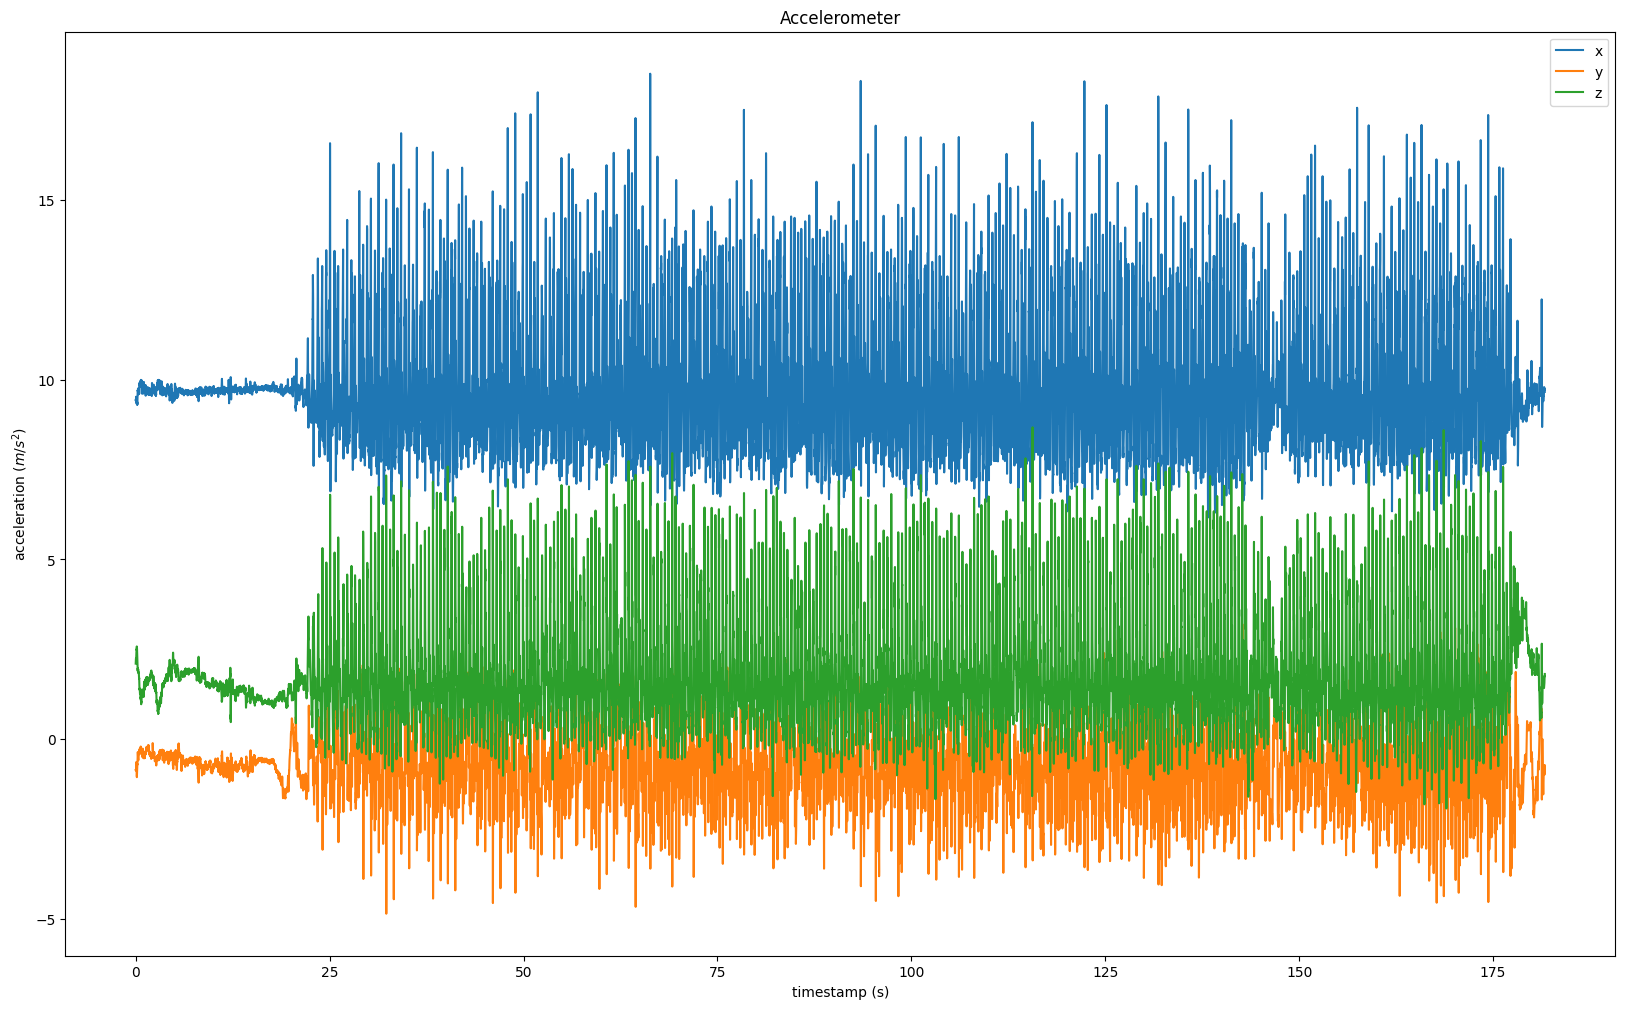

In [4]:

plt.plot(acc.ts, acc[["x", "y", "z"]], label=["x", "y", "z"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer")
plt.legend()
plt.show()


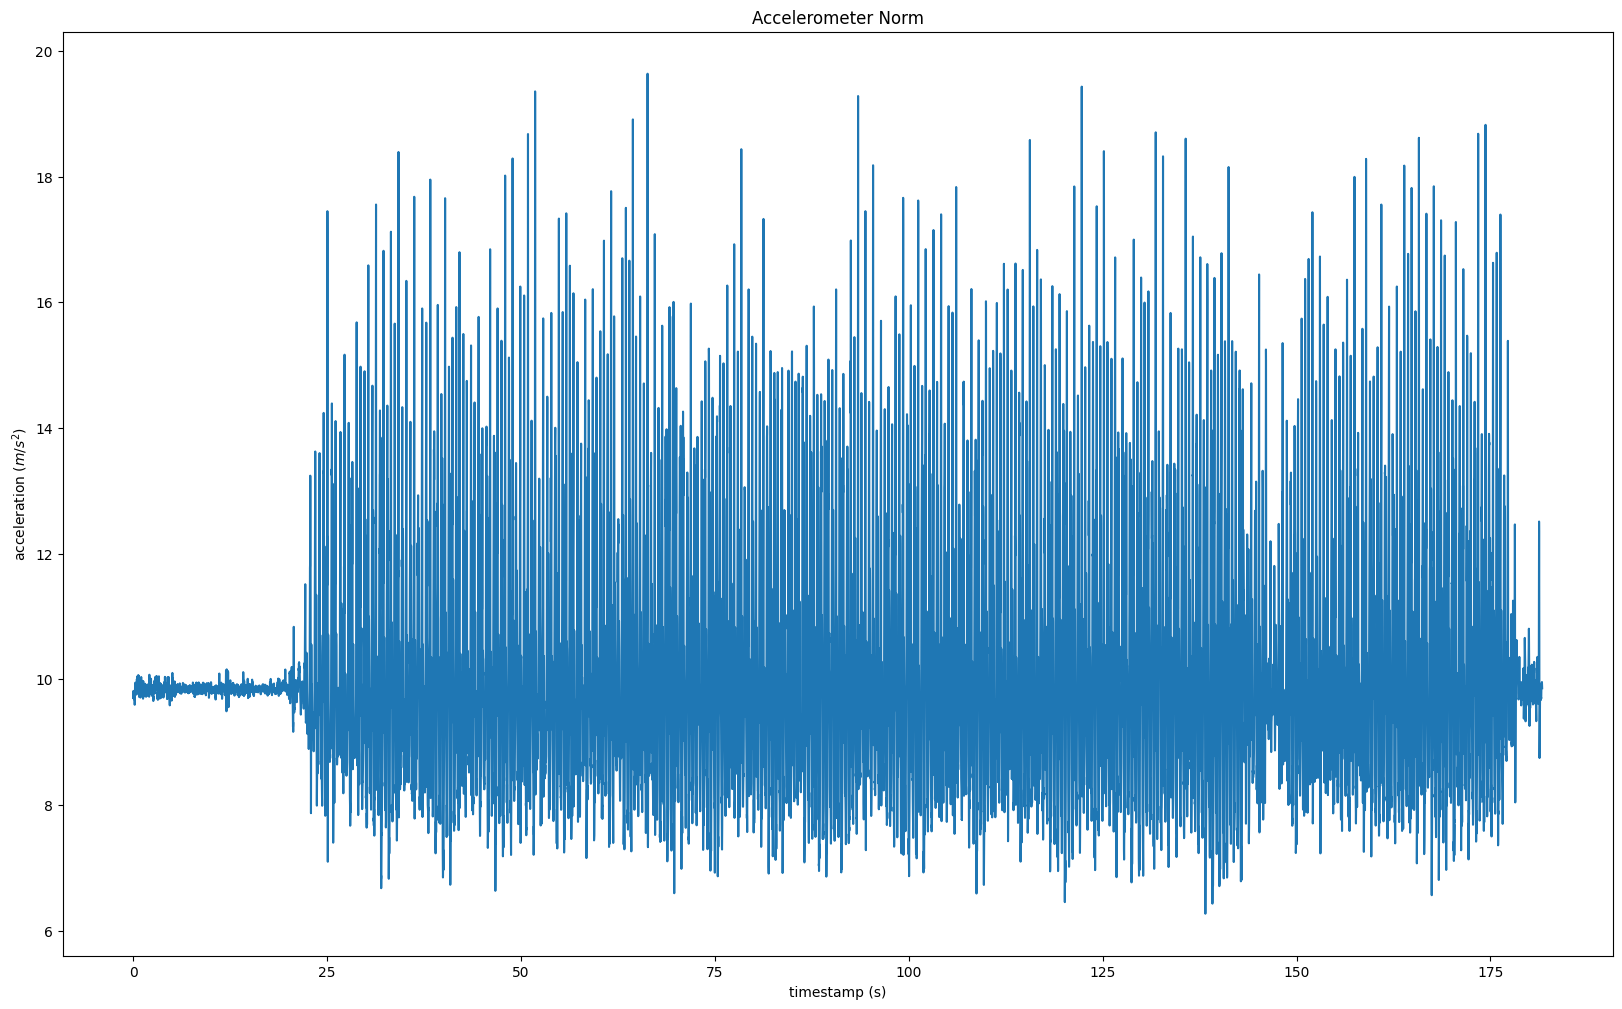

In [5]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)

acc.reset_index()

plt.plot(acc.ts, acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

Text(0.5, 1.0, 'Accelerometer Norm')

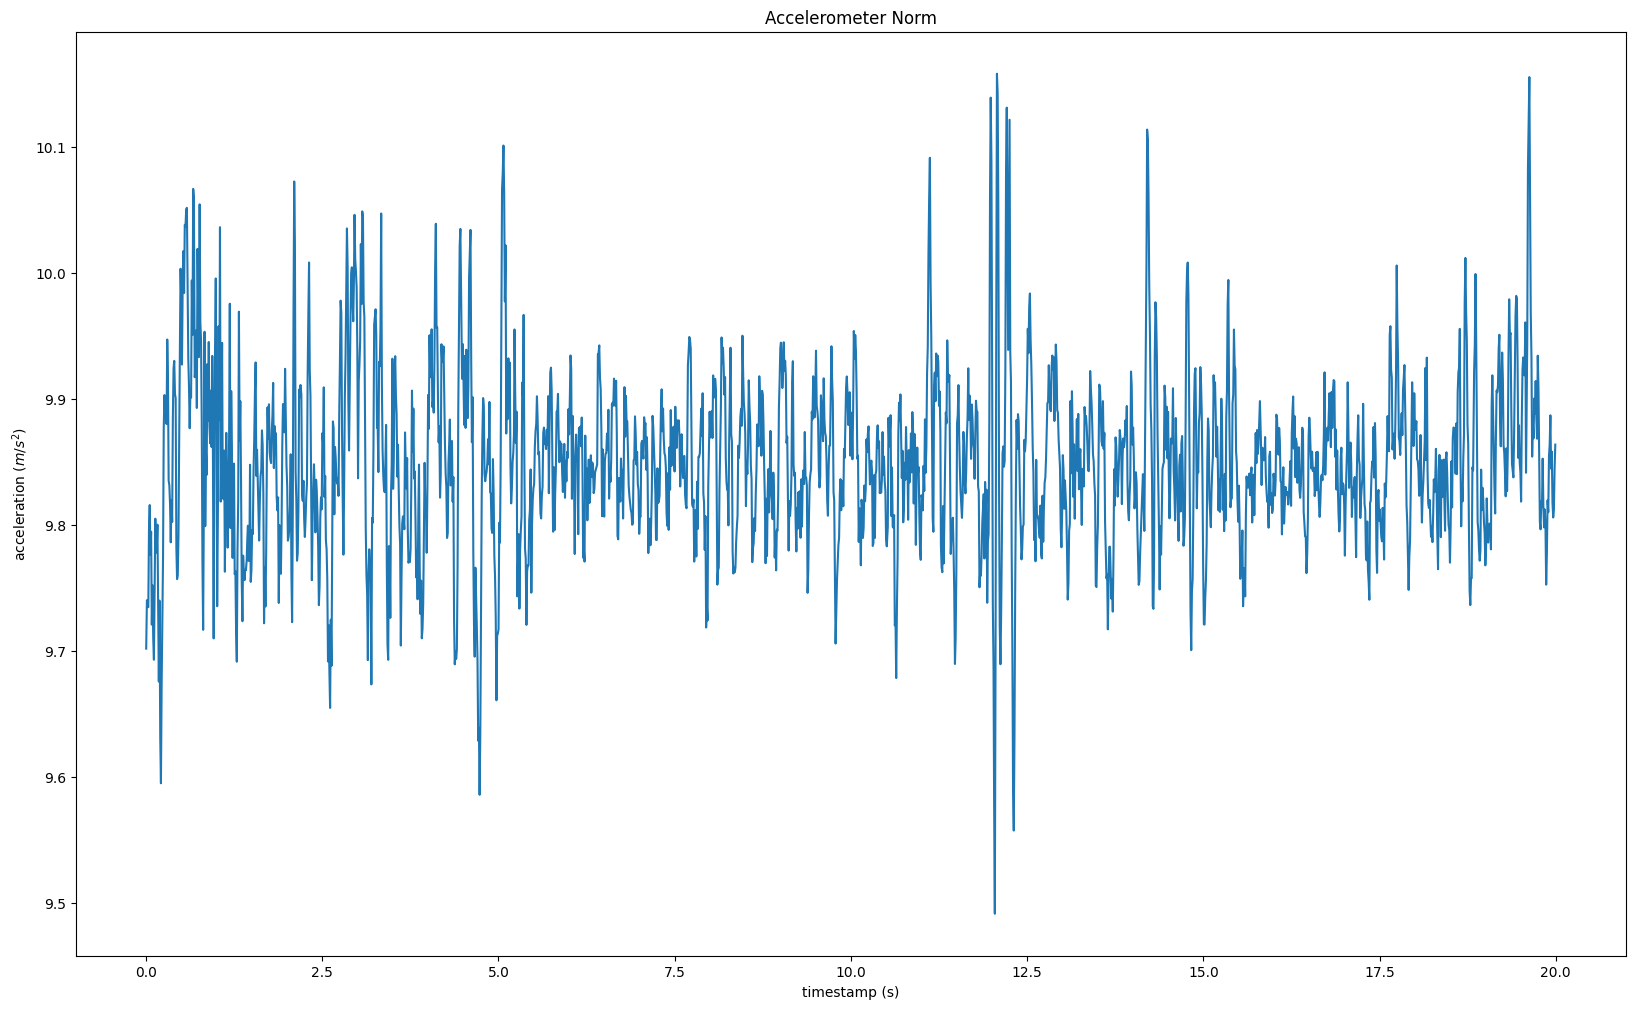

In [6]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)

# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc[(acc.ts >= 0) & (acc.ts < 20)]
time_filter_acc.reset_index(inplace=True, drop=True)

plt.plot(time_filter_acc.ts, time_filter_acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
# plt.show()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_56676/3751476274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(


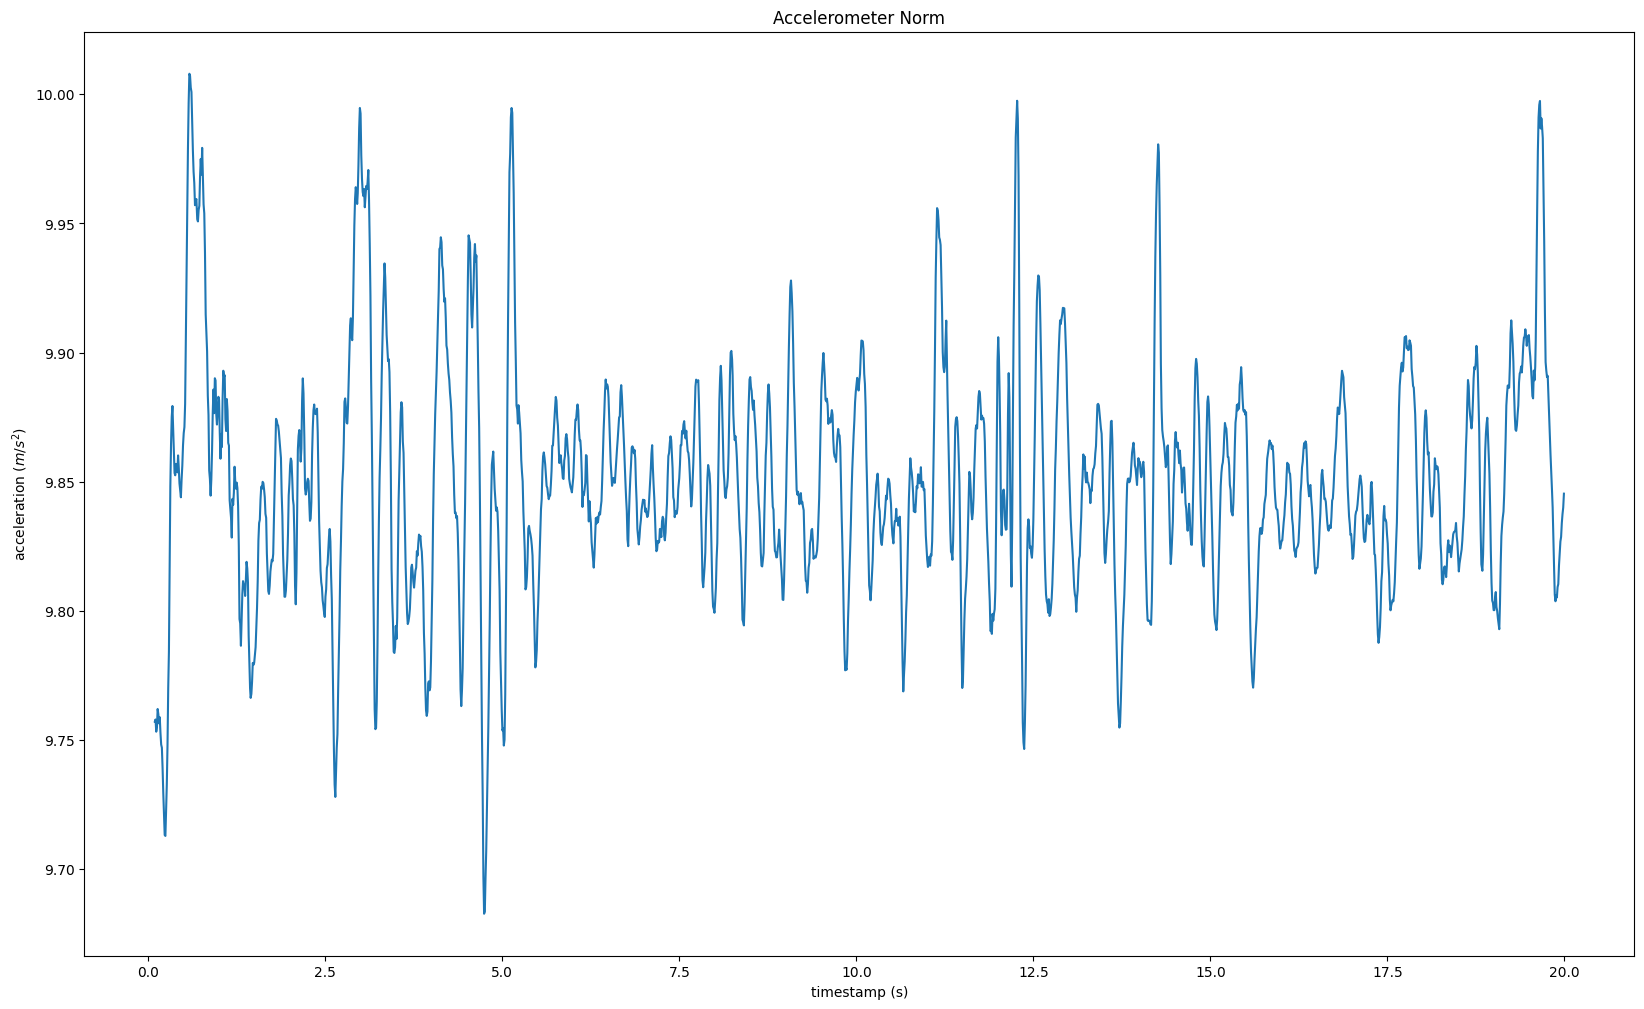

In [7]:

# 移動平均フィルターをかける
time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
    10).mean()

plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()



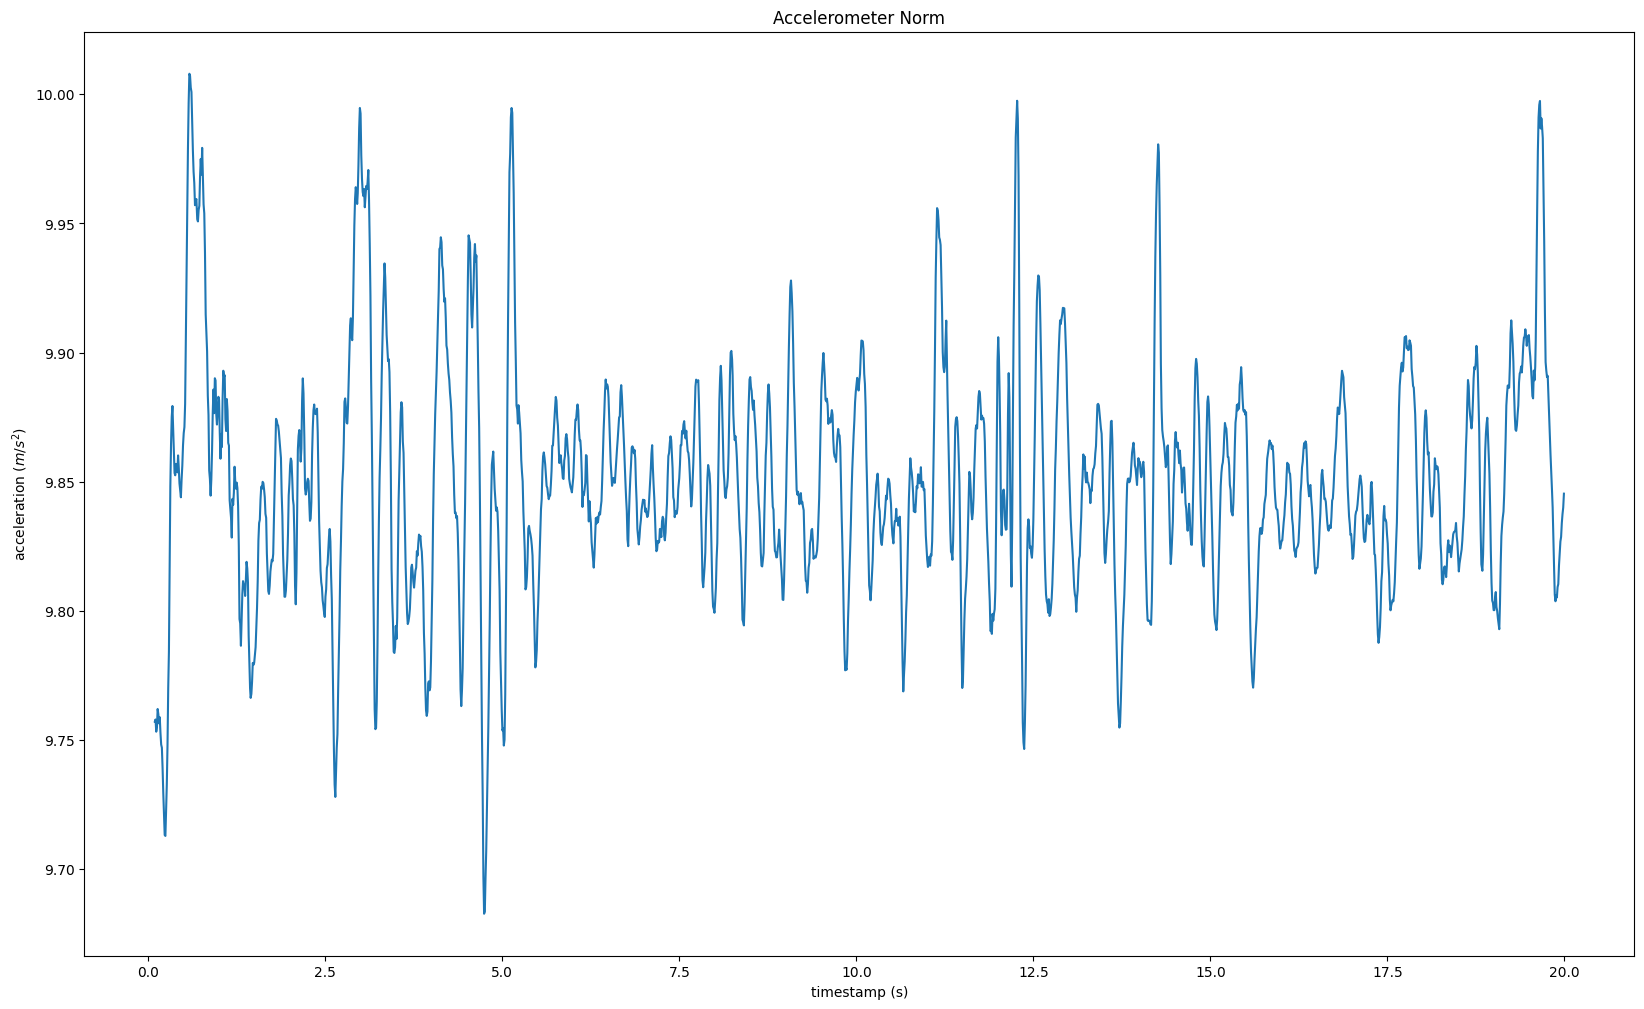

In [8]:
# ピーク検出
from scipy.signal import find_peaks

peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=12, distance=20)
plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.plot(time_filter_acc.ts[peaks],
         time_filter_acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()


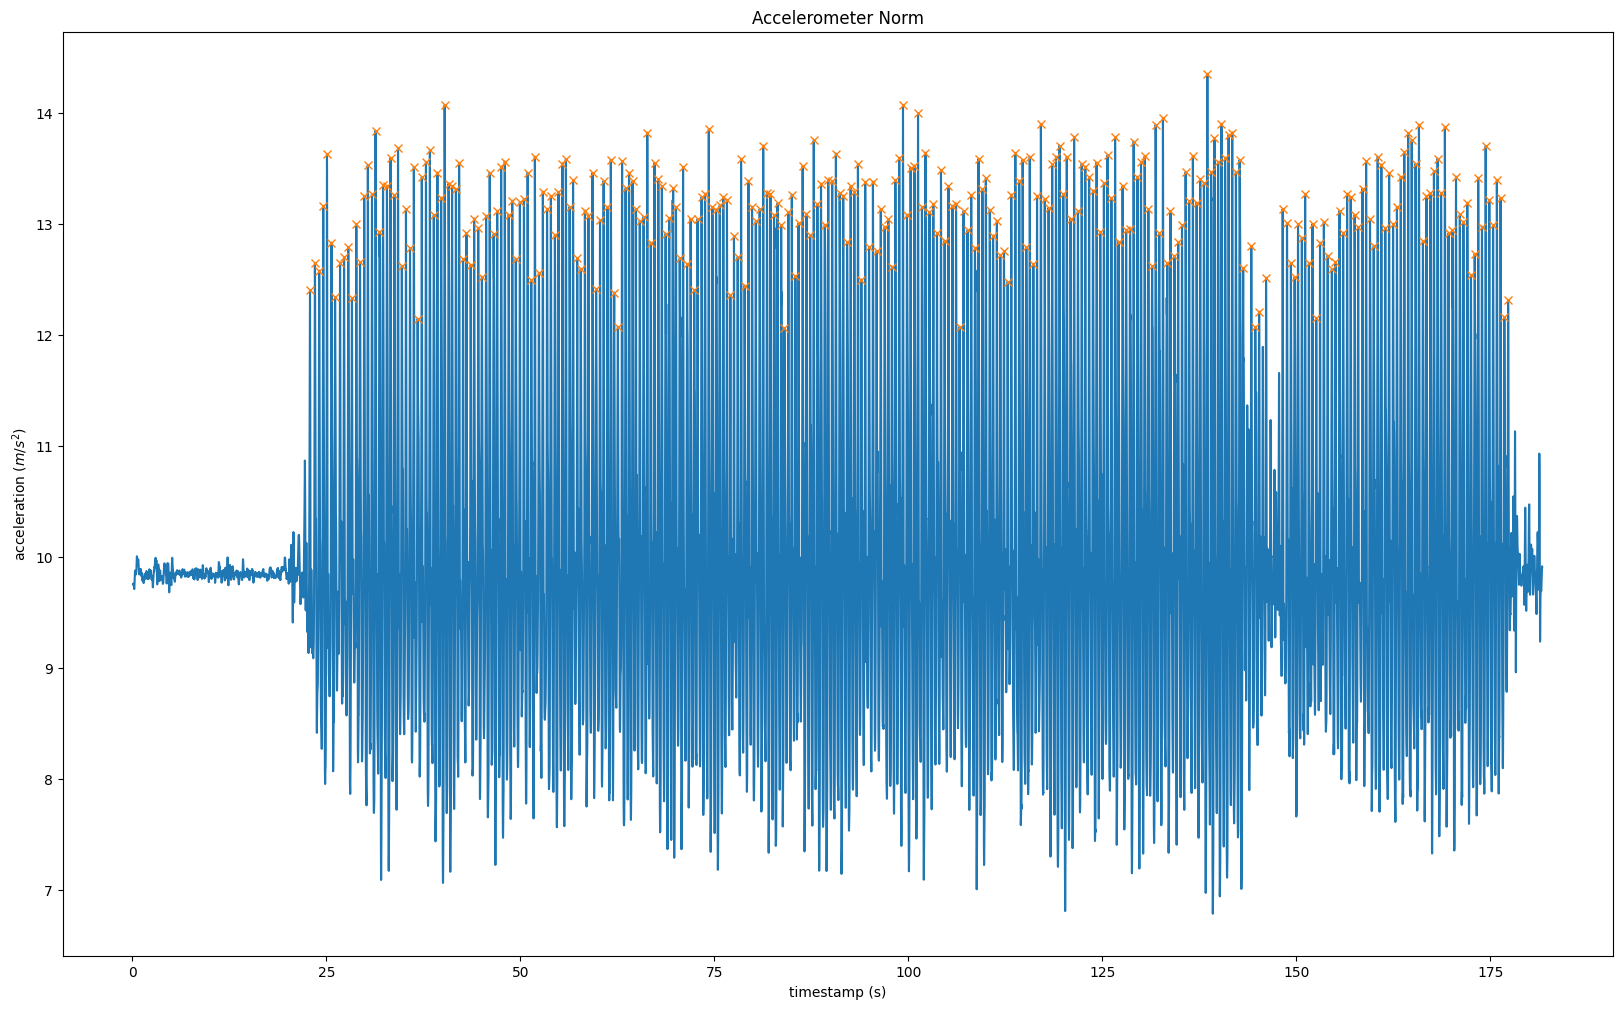

In [9]:

acc['rolling_norm'] = acc['norm'].rolling(10).mean()

peaks, _ = find_peaks(acc['rolling_norm'], height=12, distance=20)

plt.plot(acc.ts, acc['rolling_norm'])
plt.plot(acc.ts[peaks], acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

# time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
#     10).mean()

# peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=11, distance=20)

# plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
# plt.plot(time_filter_acc.ts[peaks],
#          time_filter_acc['rolling_norm'][peaks], "x")
# plt.xlabel("timestamp (s)")
# plt.ylabel("acceleration ($m/s^2$)")
# plt.title("Accelerometer Norm")
# plt.show()


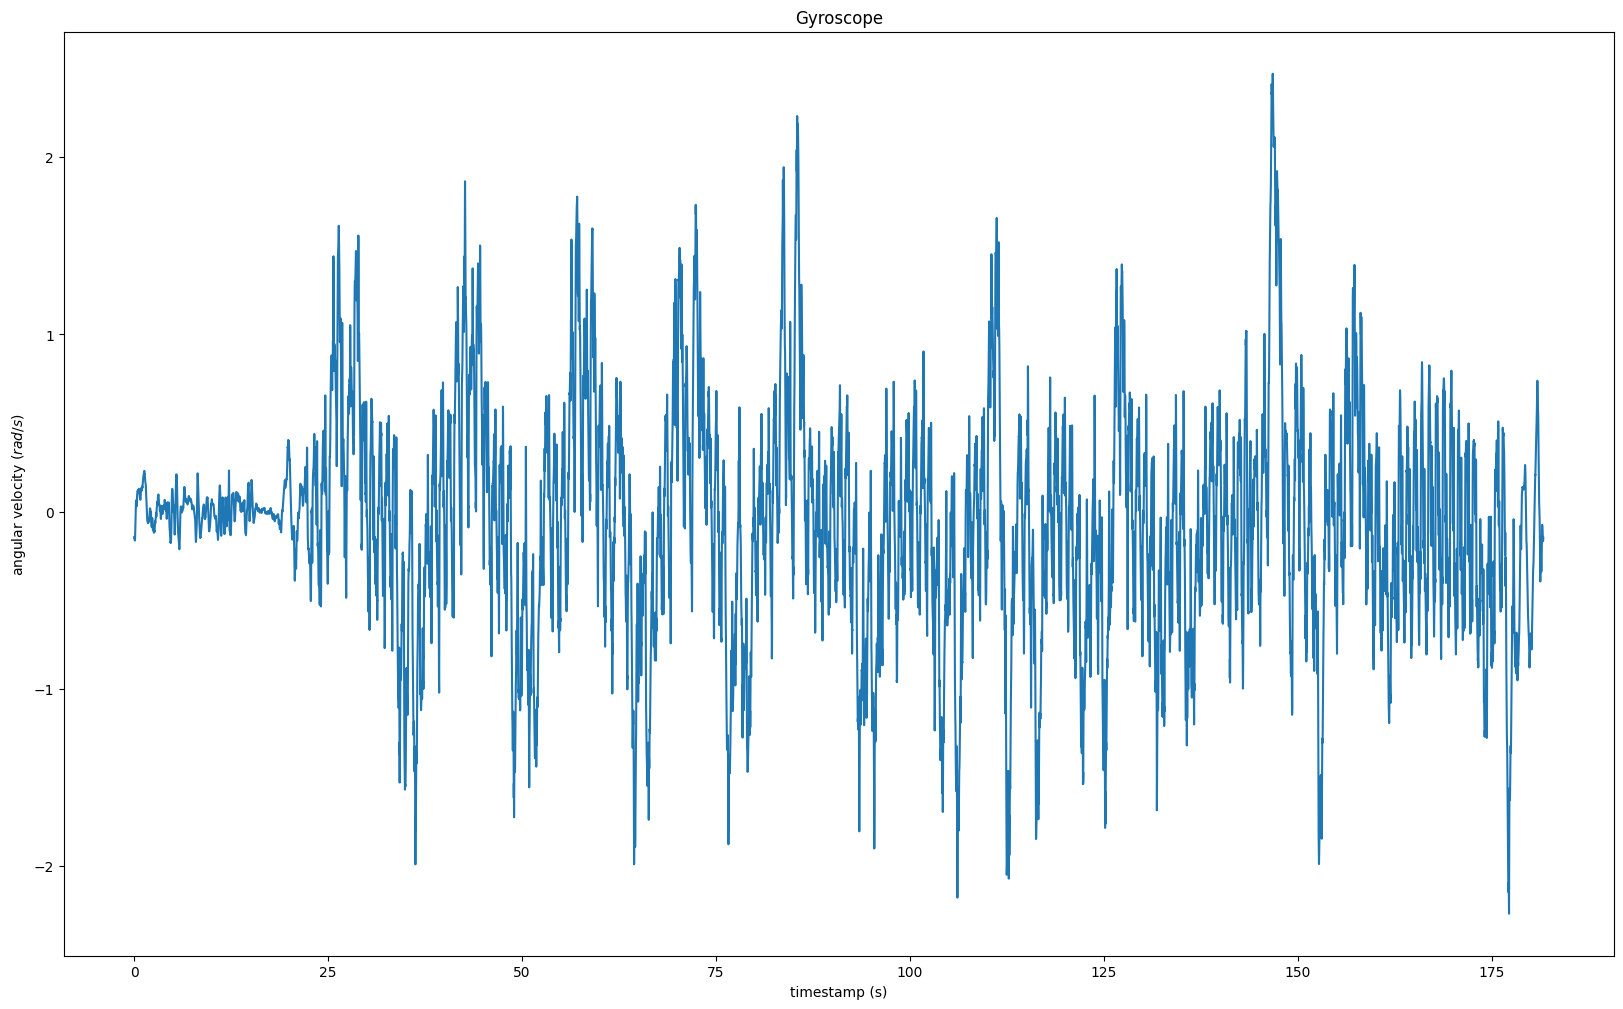

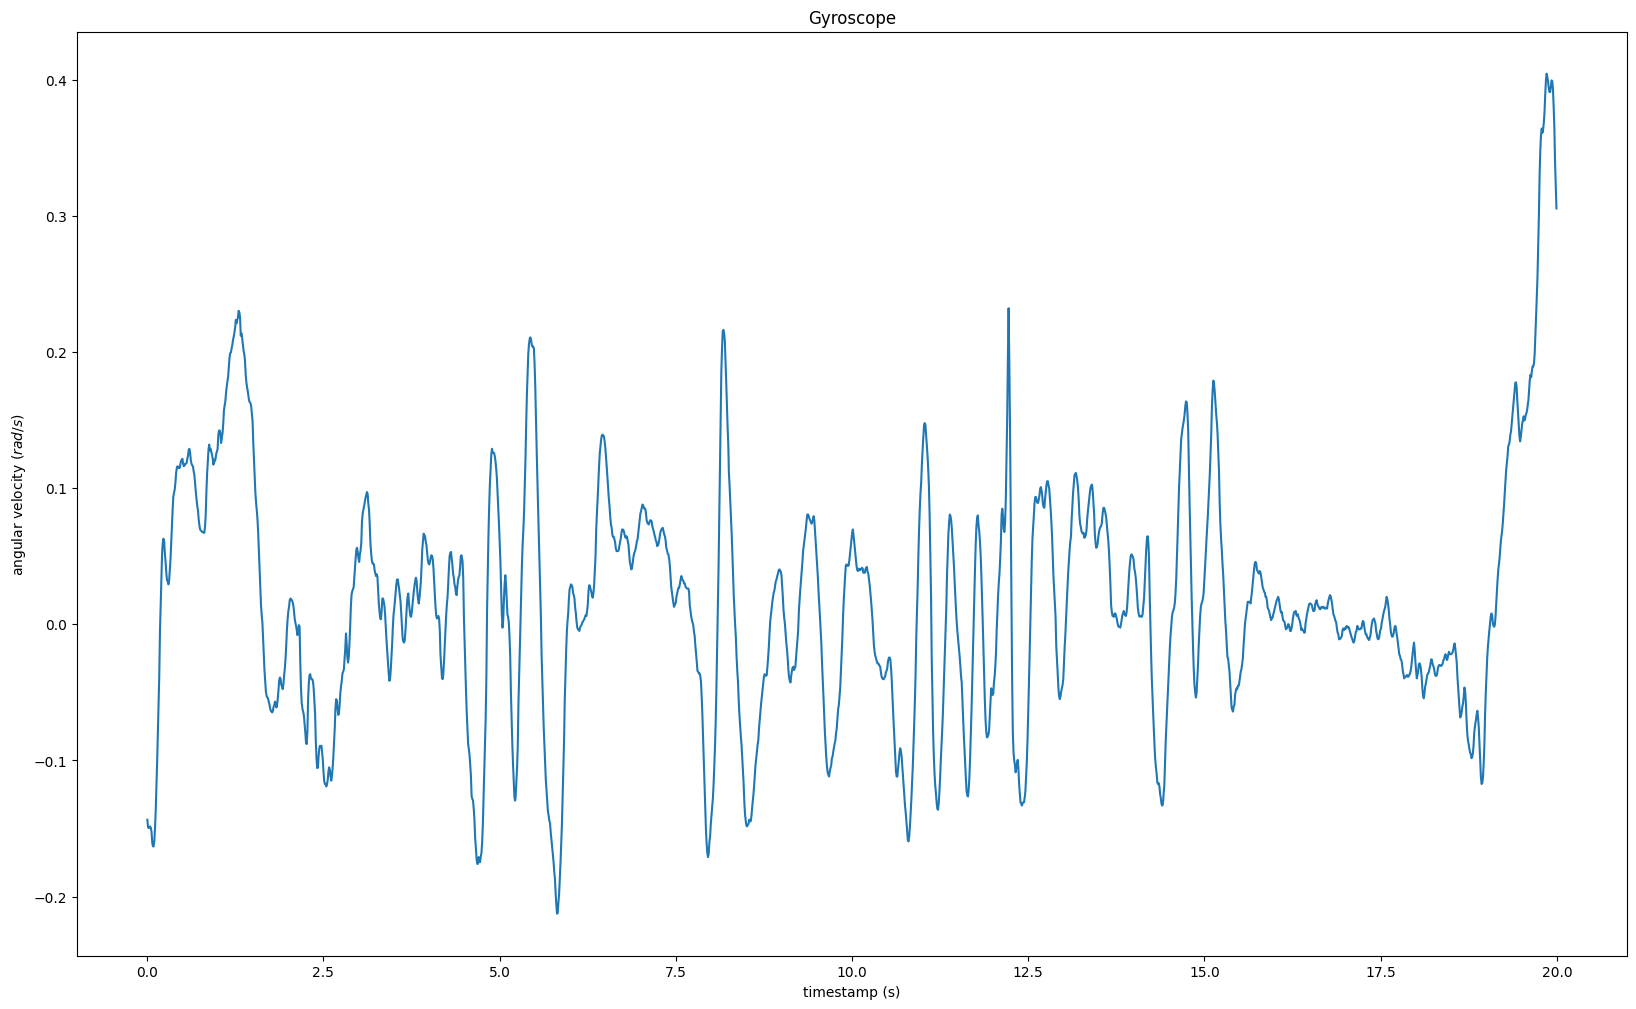

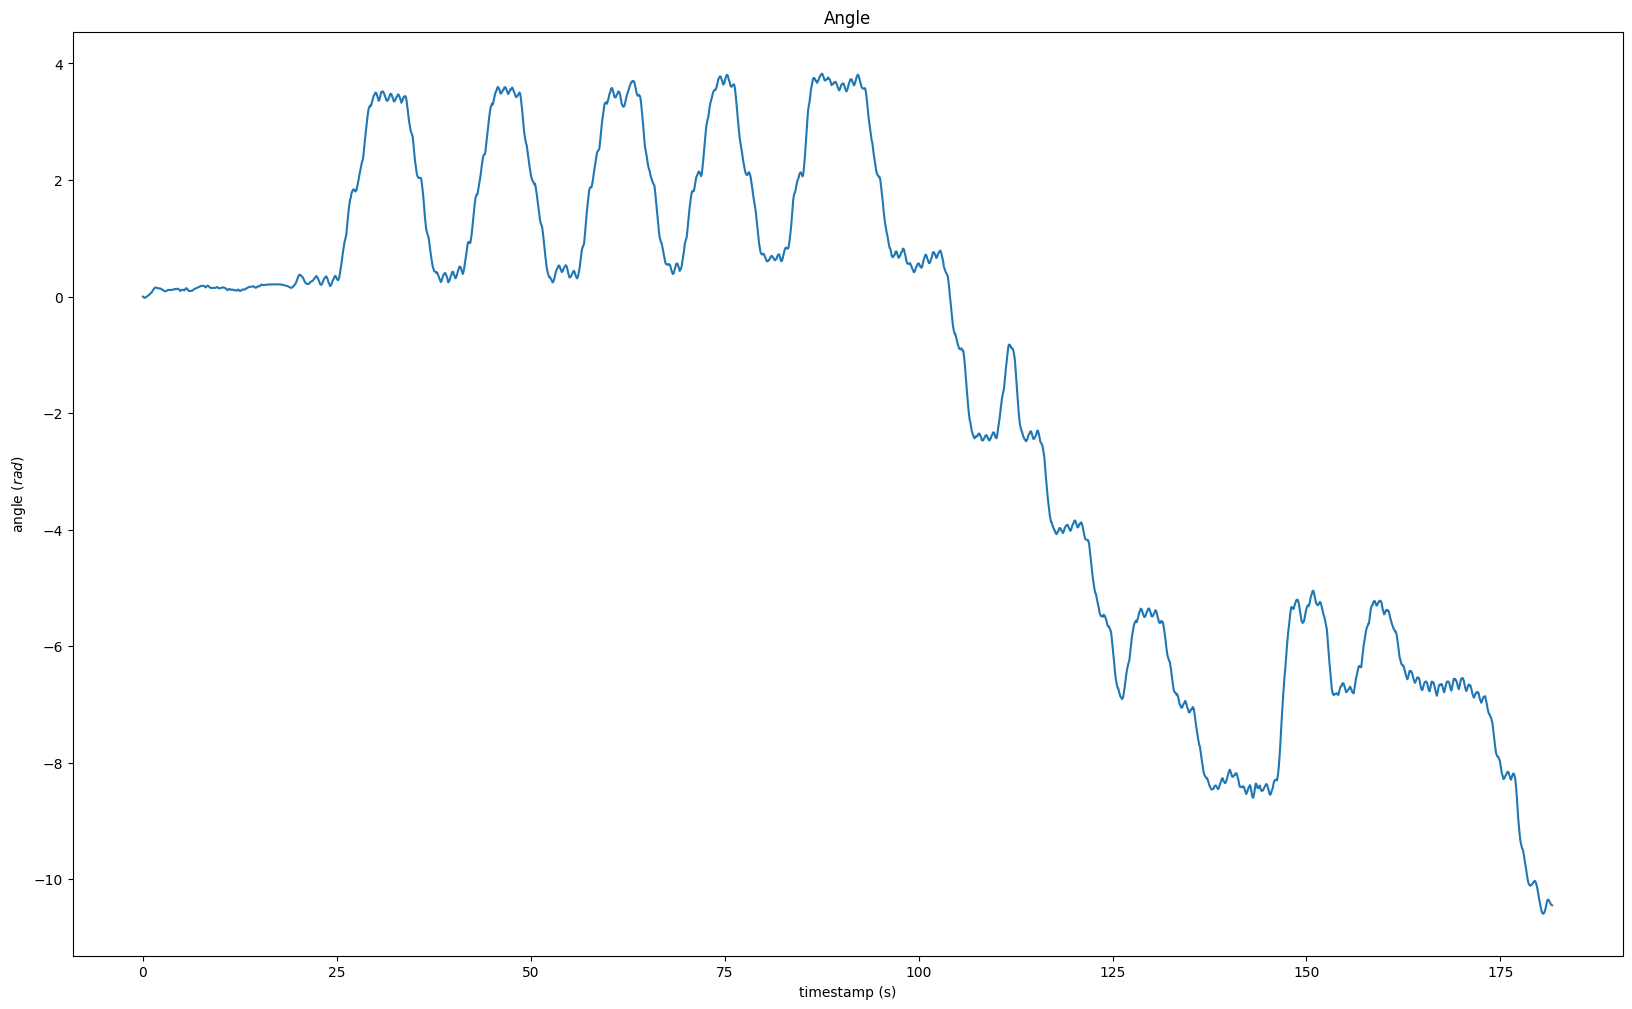

In [10]:

def convert_to_gyro_rate(angle_df: pd.DataFrame) -> pd.DataFrame:
    gyro_rate = pd.DataFrame()
    gyro_rate['ts'] = angle_df['ts']
    # 1つ前の角度との差分を取得して、微分を近似
    # 注意：この方法はノイズが強調される可能性がある
    gyro_rate['x'] = angle_df['x'].diff() / 0.01
    gyro_rate = gyro_rate.dropna()  # 最初のデータポイントでのNaNを削除
    return gyro_rate




plt.plot(gyro.ts, gyro['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angular velocity ($rad/s$)")
plt.title("Gyroscope")
plt.show()

# gyroデータを20秒以内に絞り込む
time_filter_gyro = gyro[(gyro.ts >= 0) & (gyro.ts < 20)]
time_filter_gyro.reset_index(inplace=True, drop=True)

# plot
plt.plot(time_filter_gyro.ts, time_filter_gyro['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angular velocity ($rad/s$)")
plt.title("Gyroscope")
plt.show()



# 角速度を積分して角度に変換
angle_df=estimate.convert_to_angle_from_gyro(gyro)

# 角度のデータをplot
plt.plot(angle_df.ts, angle_df['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()



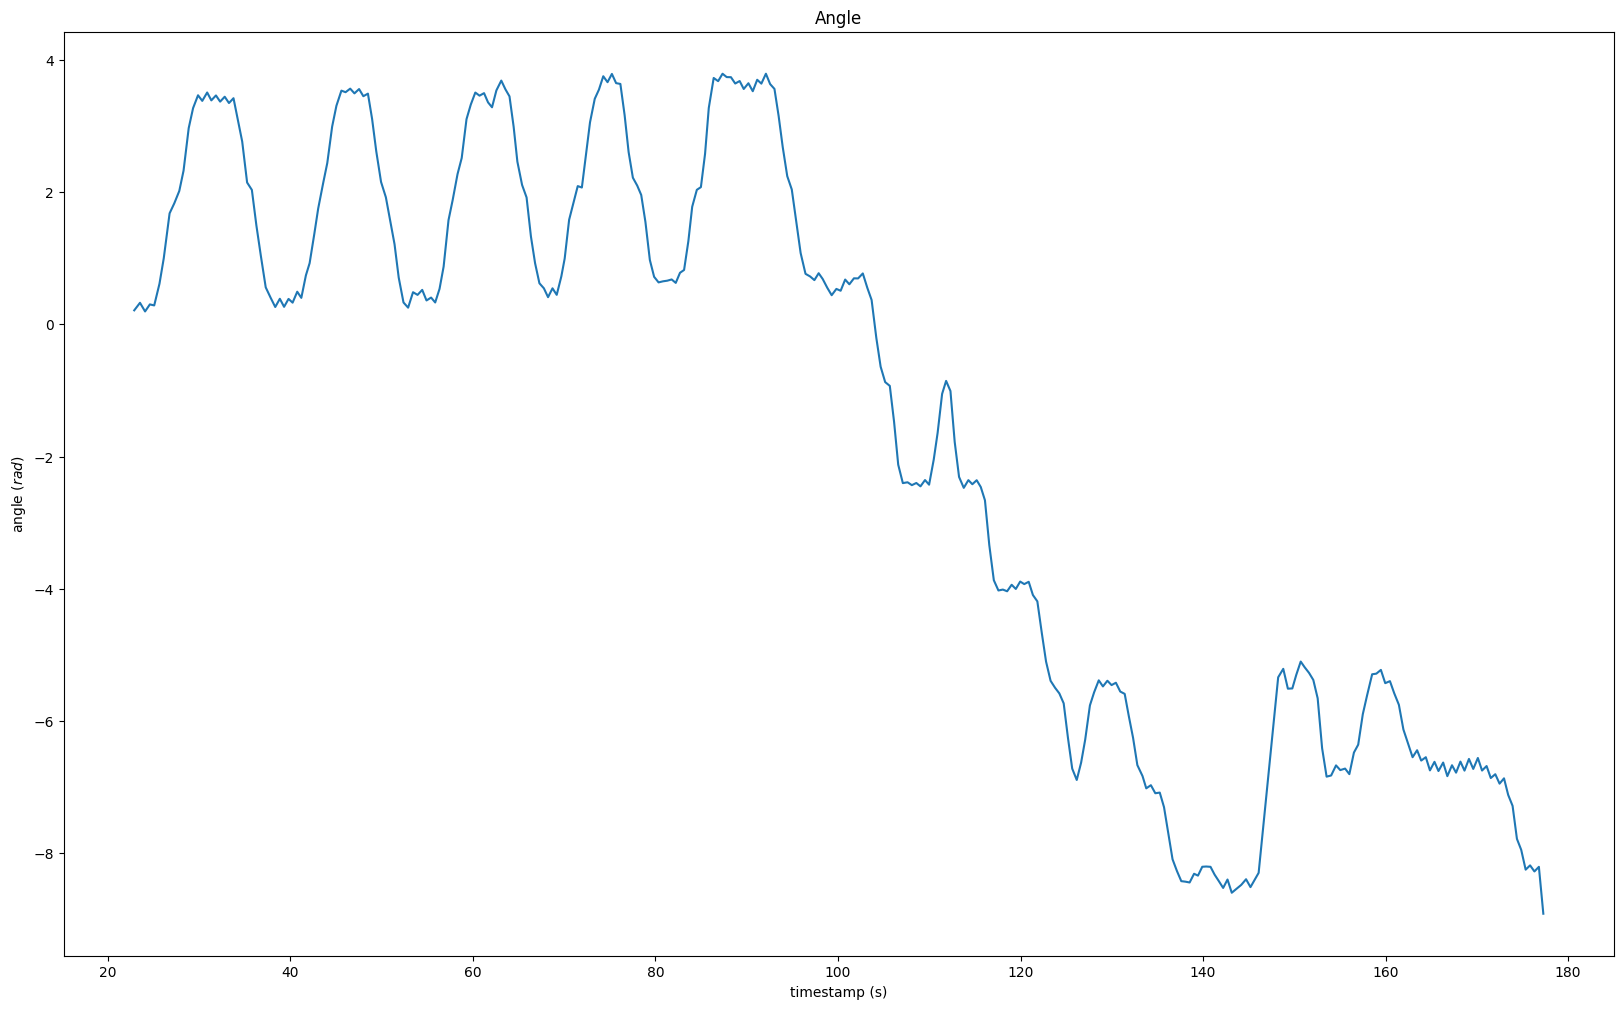

In [11]:

# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()

angle_in_step_timing= estimate.convert_to_peek_angle(gyro, acc, peaks)

plt.plot(angle_in_step_timing.ts, angle_in_step_timing['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()


In [12]:

dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")



edit_map_dict = {}
for floor_name in FLOOR_NAMES:
    edit_map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01_edited.bmp")

floor_name = gt_ref.floor[0] 



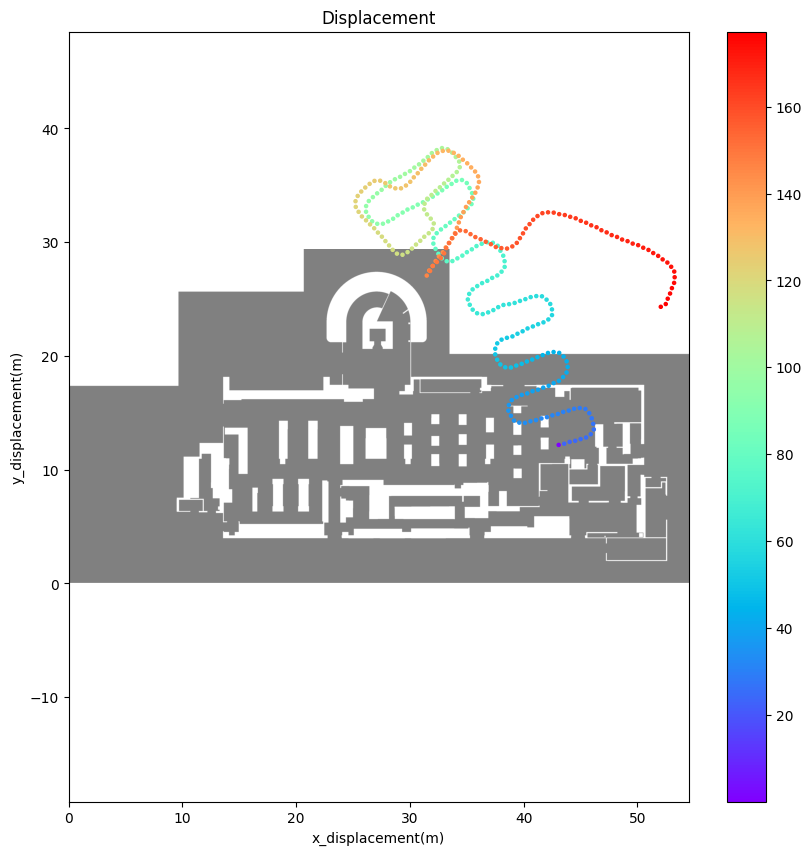

In [13]:

cumulative_displacement_df=estimate.convert_to_peek_angle_and_compute_displacement_by_gyro(
    gyro, acc, peaks, 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]}, gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(cumulative_displacement_df.x_displacement, cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts, cmap="rainbow",s=5))

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()


-0.6198604432589457


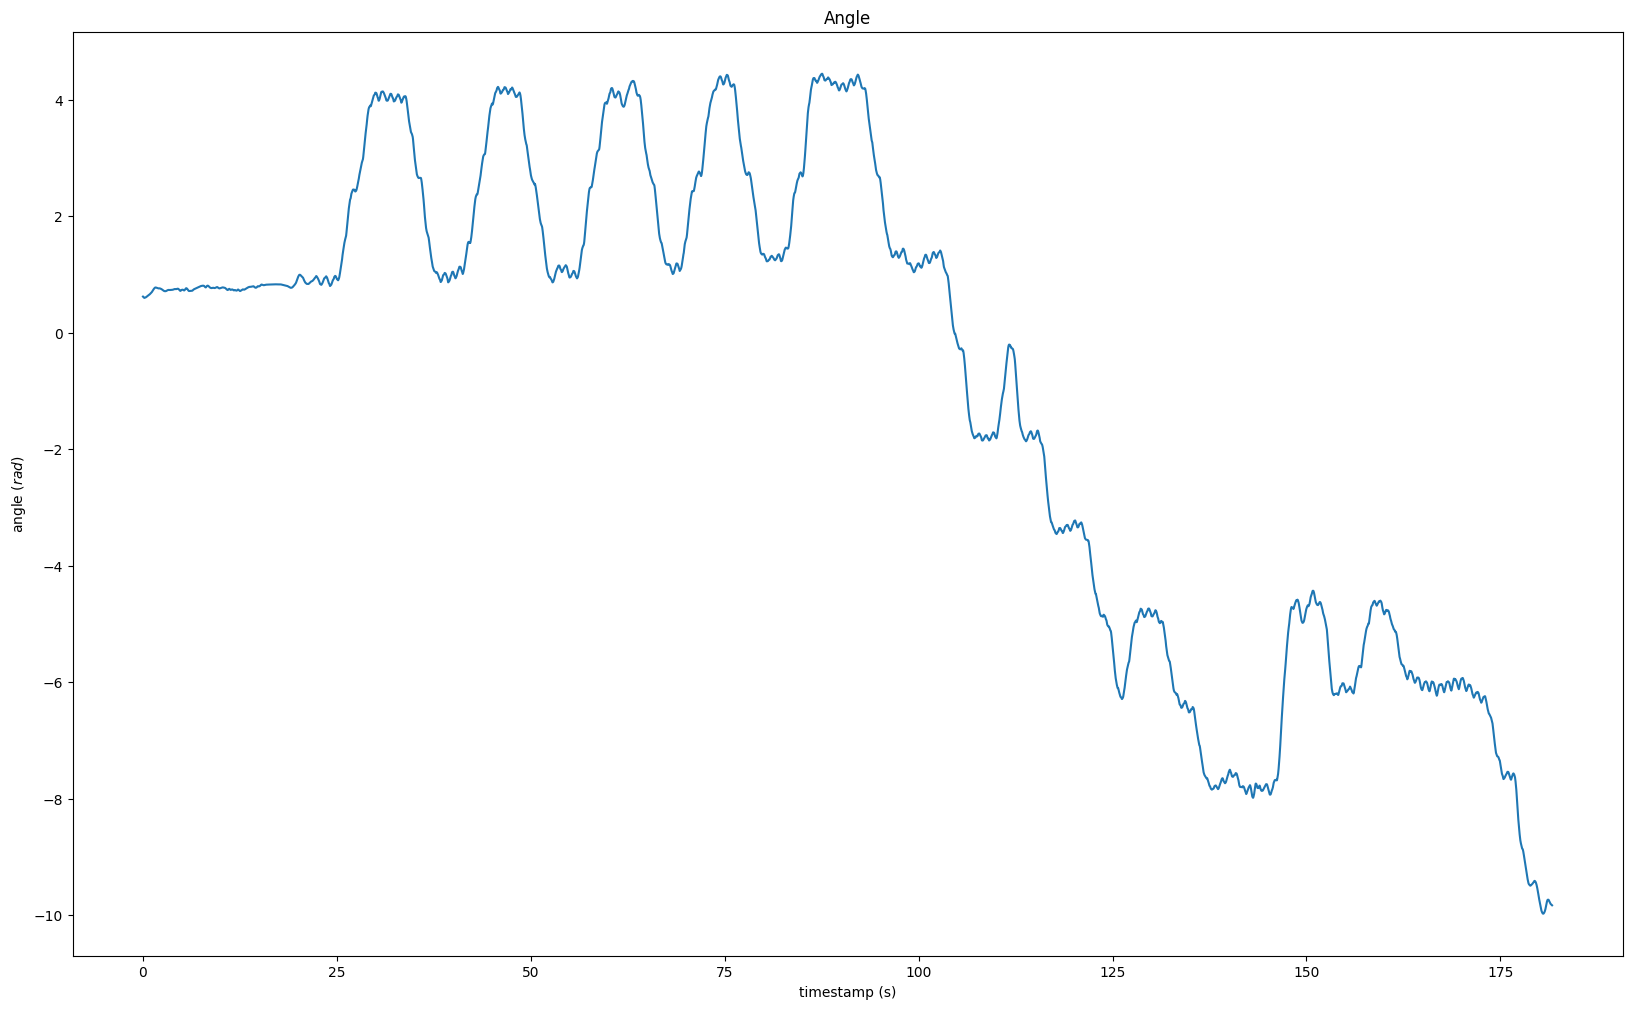

               ts  x_displacement  y_displacement is_vertical_or_horizontal
0        0.004059       43.079905       12.163538                       NaN
2300    22.887179       43.416751       12.533045                     False
2363    23.518216       43.709313       12.938517                     False
2419    24.075389       44.052284       13.302345                     False
2472    24.600236       44.354549       13.700636                     False
2520    25.076593       44.662997       14.094158                     False
2578    25.653061       44.828239       14.566064                     False
2625    26.120688       44.804580       15.065504                      True
2689    26.761847       44.471703       15.438590                     False
2741    27.276752       44.086317       15.757145                     False
2796    27.823976       43.648394       15.998440                     False
2843    28.290371       43.158091       16.096436                     False
2900    28.8

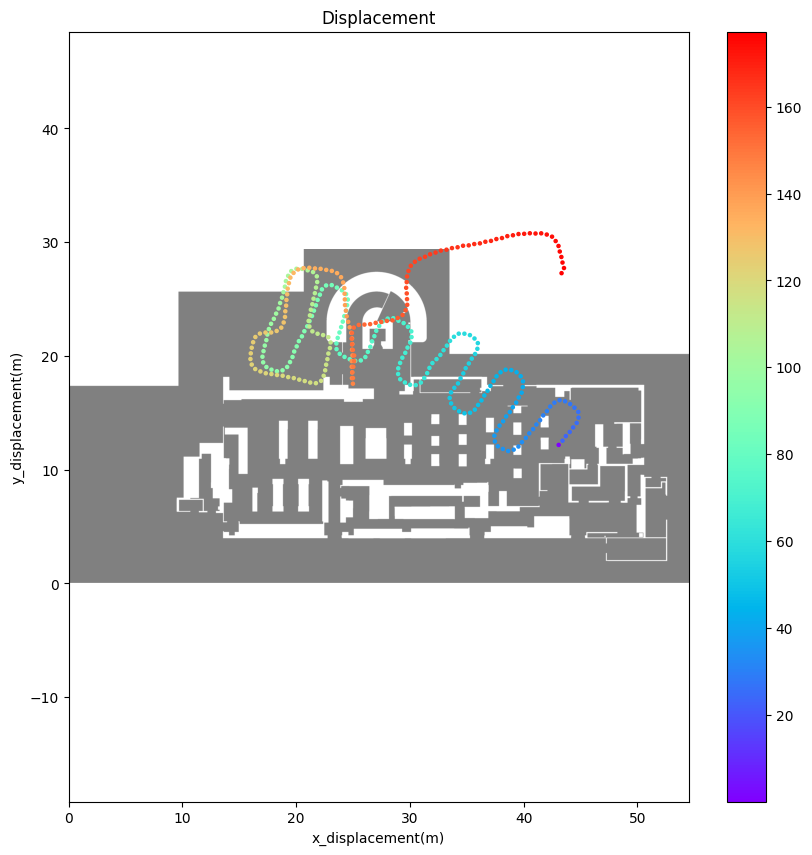

In [14]:

# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
#時間全体の中央を変数に入れる

def extract_rotation(quaternions):
    res = R.from_quat(quaternions).apply([1, 0, 0])

    return np.arctan2(res[1], res[0])


initial_direction = extract_rotation([gt_ref.q0[0],gt_ref.q1[0],gt_ref.q2[0],gt_ref.q3[0]])
diff = angle_in_step_timing['x'].values[0] - initial_direction


print(diff)

#角度
rotate_by_first_half_angle= pd.DataFrame({
    "ts":angle_df['ts'],
    "x":angle_df['x']-diff
})


plt.plot(rotate_by_first_half_angle.ts, rotate_by_first_half_angle['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()


rotate_by_first_half_angle_displacement = estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
    rotate_by_first_half_angle, acc, peaks, 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]}, gt_ref['%time'][0])

print(rotate_by_first_half_angle_displacement)

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_first_half_angle_displacement.x_displacement, rotate_by_first_half_angle_displacement.y_displacement,
                c=rotate_by_first_half_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



[{'drift': 0.005999999999999986, 'euclidean_distance': 2.372196195127707}, {'drift': 0.006999999999999987, 'euclidean_distance': 3.042934827948938}, {'drift': 0.004999999999999987, 'euclidean_distance': 3.761290495753263}, {'drift': 0.007999999999999985, 'euclidean_distance': 4.998853949433544}, {'drift': 0.003999999999999988, 'euclidean_distance': 5.892063373198102}, {'drift': 0.008999999999999982, 'euclidean_distance': 7.252746304660756}, {'drift': 0.002999999999999989, 'euclidean_distance': 8.189906332882138}, {'drift': 0.0019999999999999896, 'euclidean_distance': 10.526540916676936}, {'drift': 0.0009999999999999905, 'euclidean_distance': 12.859049852057948}, {'drift': -8.673617379884035e-18, 'euclidean_distance': 15.166206638479018}, {'drift': -0.0010000000000000078, 'euclidean_distance': 17.434203468214324}, {'drift': -0.002000000000000007, 'euclidean_distance': 19.65239163342735}, {'drift': -0.003000000000000006, 'euclidean_distance': 21.81173424838585}, {'drift': -0.004000000000

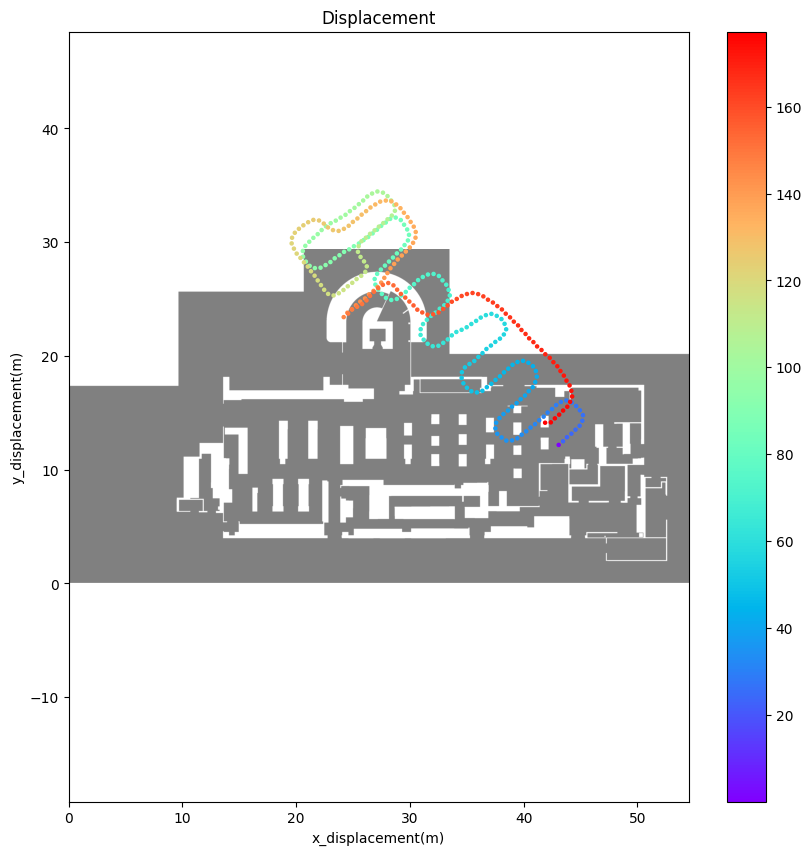

In [15]:


def search_optimal_drift_from_angle(acc:pd.DataFrame,angle: pd.DataFrame, gt_ref: pd.DataFrame):
    original_angle = angle.copy()
    # 探索するドリフトの範囲
    drift_range = np.arange(-0.01, 0.01, 0.001)

    drift_and_euclidean_list: list[dict[str, float]] = []

    for drift in drift_range:

        angle_copy = original_angle.copy()

        elapsed_time = angle_copy['ts'] - angle_copy['ts'].iloc[0]

        # ドリフトを経過時間に応じて増加させる
        angle_copy['x'] -= drift * elapsed_time

        cumulative_displacement_df_copy = estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
            angle_copy, acc, peaks, 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]}, gt_ref['%time'][0])
        
        cumulative_displacement_df_copy.reset_index(inplace=True, drop=True)
        # cumulative_displacement_df_copyの最後の行の値を取得
        last_row = cumulative_displacement_df_copy.tail(1)

        # ユークリッド距離を計算
        euclidean_distance = np.sqrt(
            (last_row['x_displacement'].values[0]-gt_ref.x[1])**2 + (last_row['y_displacement'].values[0]-gt_ref.y[1])**2)
        drift_and_euclidean_list.append(
            {"drift": drift, "euclidean_distance": euclidean_distance}) 
        

    #sortする
    drift_and_euclidean_list.sort(key=lambda x: x['euclidean_distance'])
    print(drift_and_euclidean_list)

    
    # 一番ユークリッド距離が小さいドリフトを取得
    optimal_drift_and_euclidean = min(
        drift_and_euclidean_list, key=lambda x: x['euclidean_distance'])

    return optimal_drift_and_euclidean

optimal_drift_and_euclidean=search_optimal_drift_from_angle(acc,rotate_by_first_half_angle,gt_ref)
print(optimal_drift_and_euclidean)

first_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_first_half_angle.ts,
    "x":rotate_by_first_half_angle.x-optimal_drift_and_euclidean['drift']*(rotate_by_first_half_angle.ts-rotate_by_first_half_angle.ts.iloc[0])
})

first_time_remove_drift_angle_displacement = estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
    first_time_remove_drift_angle, acc, peaks, 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]}, gt_ref['%time'][0])


estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(first_time_remove_drift_angle_displacement.x_displacement, first_time_remove_drift_angle_displacement.y_displacement,
                c=first_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



     angle  horizontal_and_vertical_count
0     0.86                            143
1     2.43                            142
2     0.85                            142
3     5.56                            141
4     5.57                            141
5     5.58                            141
6     2.42                            141
7     3.99                            141
8     4.00                            141
9     0.87                            140
10    4.01                            140
11    2.44                            140
12    0.84                            138
13    5.55                            137
14    3.98                            137
15    2.41                            137
16    2.40                            135
17    4.02                            135
18    5.61                            135
19    5.59                            135
20    0.90                            135
21    0.83                            135
22    0.89                        

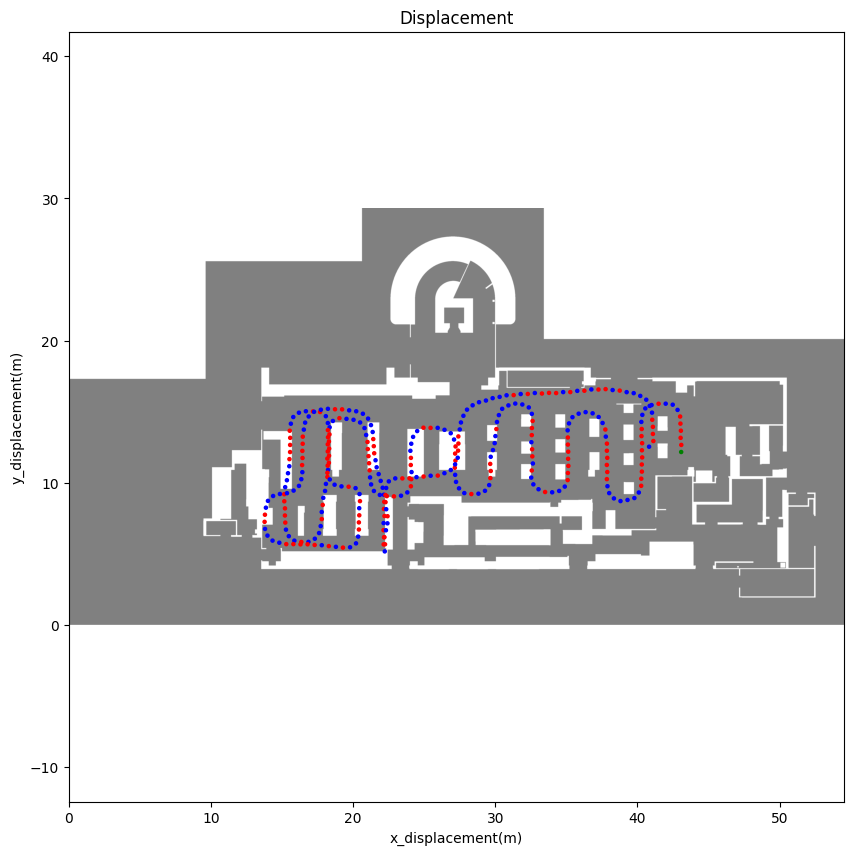

In [16]:

# 歩行ステップ時の角度に絞る
first_time_remove_drift_angle_matched_data=estimate.match_data(first_time_remove_drift_angle,
                                                               angle_in_step_timing['ts'])

angle_by_vertical_horizontal=estimate.find_best_alignment_angle(
    first_time_remove_drift_angle_matched_data,gt_ref,edit_map_dict,floor_name,dx,dy)

straight_angle=pd.DataFrame({
    "ts":first_time_remove_drift_angle.ts,
    "x":first_time_remove_drift_angle.x+angle_by_vertical_horizontal
})


straight_angle_displacement = estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
    straight_angle, acc, peaks, 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]}, gt_ref['%time'][0])


print(straight_angle_displacement.reset_index(drop=True))

estimate.plot_map(map_dict,floor_name, dx, dy)

colors = straight_angle_displacement['is_vertical_or_horizontal'].map({True: 'r', False: 'b', np.nan: 'g'})
plt.scatter(straight_angle_displacement.x_displacement, straight_angle_displacement.y_displacement,
            c=colors, s=5)
# plt.scatter(straight_angle_displacement.x_displacement, straight_angle_displacement.y_displacement,
#                 c=straight_angle_displacement.ts, cmap="rainbow",s=5)

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()


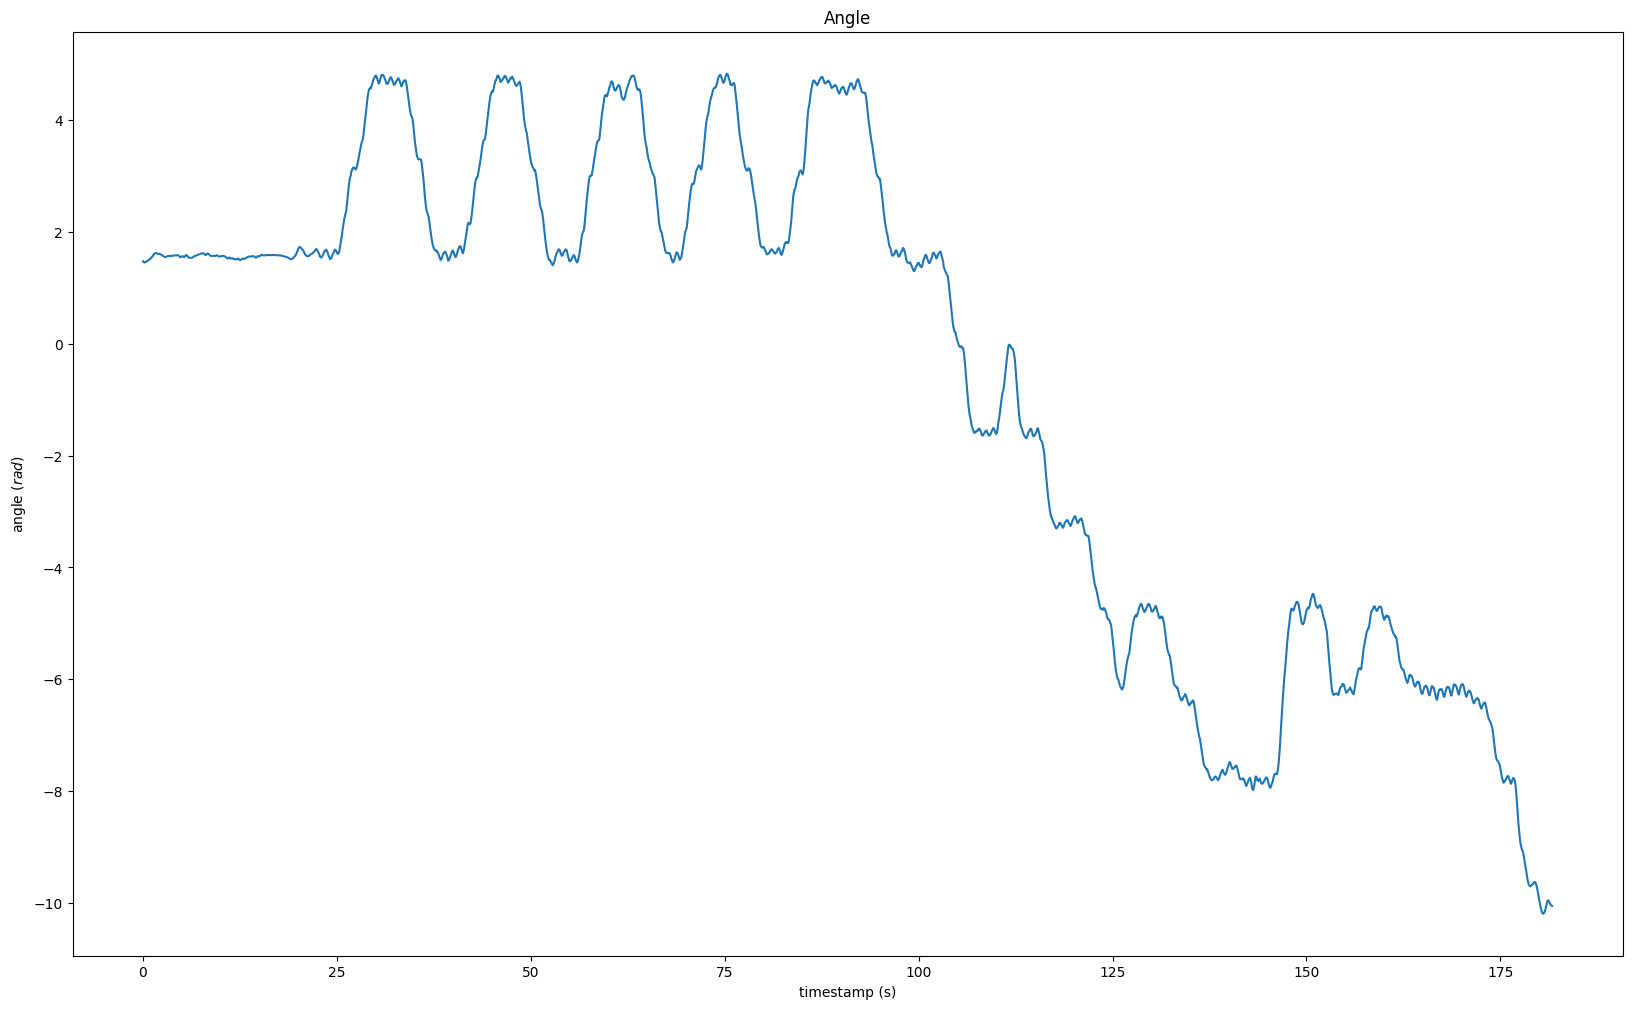

In [17]:

plt.plot(straight_angle.ts, straight_angle['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()



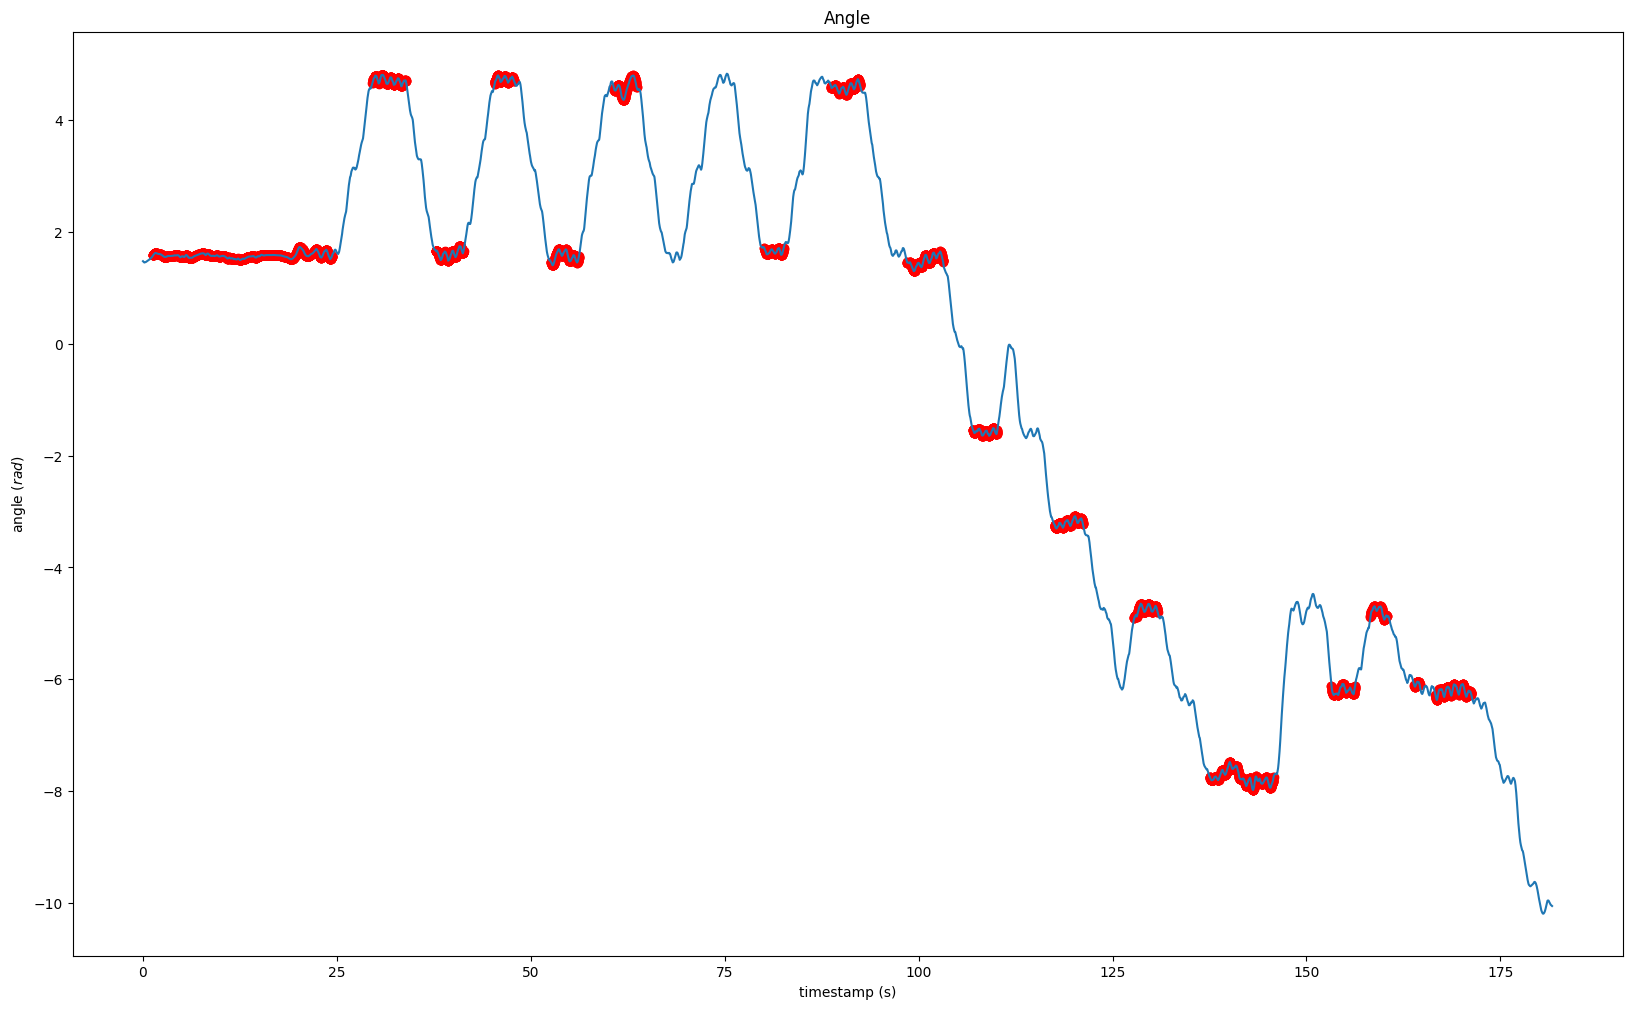

In [18]:

# 安定歩行区間を設けて，その区間に入っている場合角度を補正する
# 安定歩行区間とは，角度が一定範囲内に数秒間収まっている区間のこと
# 角度範囲は+-20度とする，数秒間は5秒とする 

def extract_stable_angle(angle_df:pd.DataFrame,stable_angle_range:float,stable_time:float)->pd.DataFrame:
    stable_angle_df=pd.DataFrame()
    stable_angle_df['ts']=angle_df['ts']
    stable_angle_df['x']=angle_df['x']
    stable_angle_df['stable_flag']=False

    start_row=stable_angle_df.iloc[0]
    elasted_time=0
    stable_flag=False
    for index, row in stable_angle_df.iterrows():
        if(start_row['x']-stable_angle_range<=row['x']<=start_row['x']+stable_angle_range ):
            elasted_time=row['ts']-start_row['ts']
            if(elasted_time>=stable_time):
                stable_flag=True
        else:
            if(stable_flag==True):
                stable_flag=False

                # stable_row.nameからrow.nameまでの平均を求める
                average=stable_angle_df.loc[start_row.name:row.name,'x'].mean()
                # print(average)
                last_row_x=stable_angle_df.loc[row.name,'x']

                # ステップ1: データの取得
                subset_data = stable_angle_df.loc[start_row.name:row.name,'x']
                # ステップ2: 条件によるフィルタリング
                if(last_row_x-average>0):
                    filtered_values = subset_data[subset_data < average]
                else:
                    filtered_values = subset_data[subset_data > average]

                last_index = filtered_values.tail(1).index[0]
                
                if(start_row.name-average>0):
                    filtered_values = subset_data[subset_data < average]
                else:
                    filtered_values = subset_data[subset_data > average]

                first_index = filtered_values.head(1).index[0]

                # stable_angle_df.loc[start_row.name:row.name,'stable_flag']=True
                # stable_angle_df.loc[start_row.name:last_index,'stable_flag']=True
                stable_angle_df.loc[first_index:last_index,'stable_flag']=True

            start_row=row

    return stable_angle_df


def correct_angle(stable_angle_df: pd.DataFrame, angle_column: str) -> pd.DataFrame:
    corrected_angle_df = stable_angle_df.copy()
    
    # 安定歩行区間での角度を修正する
    for index, row in stable_angle_df.iterrows():
        if row['stable_flag']:
            angle = row[angle_column]
            # 最も近い安定歩行の角度を計算
            # 安定歩行の角度リスト（斜め方向も考慮）
            stable_angles = [0, 1.5708, 3.14159, 4.71239, 
                     -1.5708, -3.14159, -4.71239,-6.28319,-7.85399,-9.42478,
                     0.7854, 2.35619, -0.7854, -2.35619]
            closest_angle = min(stable_angles, key=lambda x: abs(x - angle))
            # 修正する
            corrected_angle_df.at[index, angle_column] = closest_angle
    
    return corrected_angle_df

stable_angle_df=extract_stable_angle(straight_angle,0.35,3)


# plotする stable_flagがtrueのものは赤色で表示
plt.plot(stable_angle_df.ts, stable_angle_df['x'])
plt.scatter(stable_angle_df['ts'][stable_angle_df['stable_flag']],stable_angle_df['x'][stable_angle_df['stable_flag']],c='r')
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()


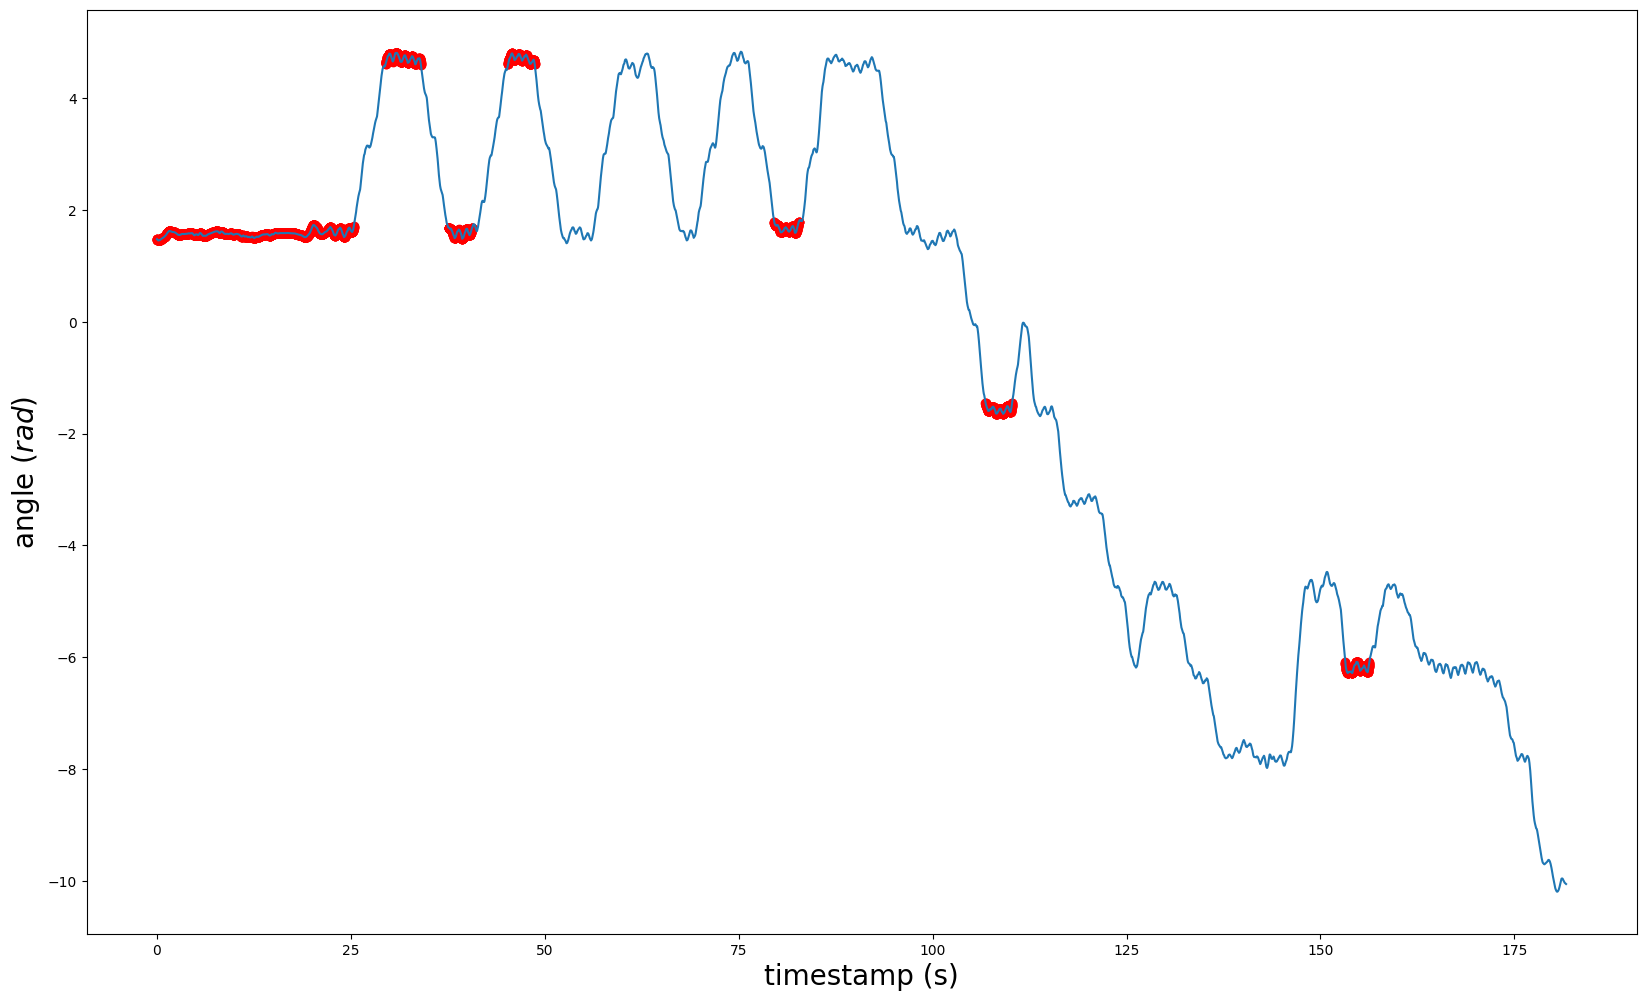

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


def refine_stable_regions_stricter(stable_angle_df, method='median', threshold_multiplier=0.5):
    refined_df = stable_angle_df.copy()
    
    # 安定歩行区間のインデックスを取得
    stable_regions = []
    start_idx = None
    for idx, row in stable_angle_df.iterrows():
        if row['stable_flag']:
            if start_idx is None:
                start_idx = idx
        else:
            if start_idx is not None:
                stable_regions.append((start_idx, idx))
                start_idx = None
                
    for start, end in stable_regions:
        subset = stable_angle_df.loc[start:end, 'x']
        
        # 指定された方法で中心値を計算
        if method == 'mean':
            center_value = subset.mean()
        elif method == 'median':
            center_value = subset.median()
        elif method == 'mode':
            center_value = subset.mode()[0]
        
        # 中心値から大きく外れるデータを安定歩行区間から除外
        threshold = threshold_multiplier * 0.35  # これは調整が必要かもしれません
        outliers = (subset < center_value - threshold) | (subset > center_value + threshold)
        refined_df.loc[outliers[outliers].index, 'stable_flag'] = False
        
    return refined_df

def is_stable_window(data, stable_angle_range):
    # ウィンドウ内の最大値と最小値の差が安定範囲内に収まっているか判定
    return (data.max() - data.min()) <= 2 * stable_angle_range

def extract_stable_angle_with_sliding_window(angle_df: pd.DataFrame, stable_angle_range: float, stable_time: float) -> pd.DataFrame:
    stable_angle_df = angle_df.copy()
    stable_angle_df['stable_flag'] = False

    window_size = int(stable_time / (angle_df['ts'].iloc[1] - angle_df['ts'].iloc[0]))  # ウィンドウサイズの計算（データポイント数）

    for i in range(len(angle_df) - window_size + 1):
        window_data = angle_df.iloc[i:i+window_size]['x']
        if is_stable_window(window_data, stable_angle_range):
            stable_angle_df.loc[angle_df.index[i:i+window_size], 'stable_flag'] = True

    return stable_angle_df


# スライドウィンドウを使用した関数を適用
stable_angle_df = extract_stable_angle_with_sliding_window(straight_angle, 0.1, 3)
# プロット
plt.plot(stable_angle_df.ts, stable_angle_df['x'])
plt.scatter(stable_angle_df['ts'][stable_angle_df['stable_flag']], stable_angle_df['x'][stable_angle_df['stable_flag']], c='r')
plt.xlabel("timestamp (s)",fontsize=20)
plt.ylabel("angle ($rad$)",fontsize=20)
# plt.title("Angle")
plt.show()



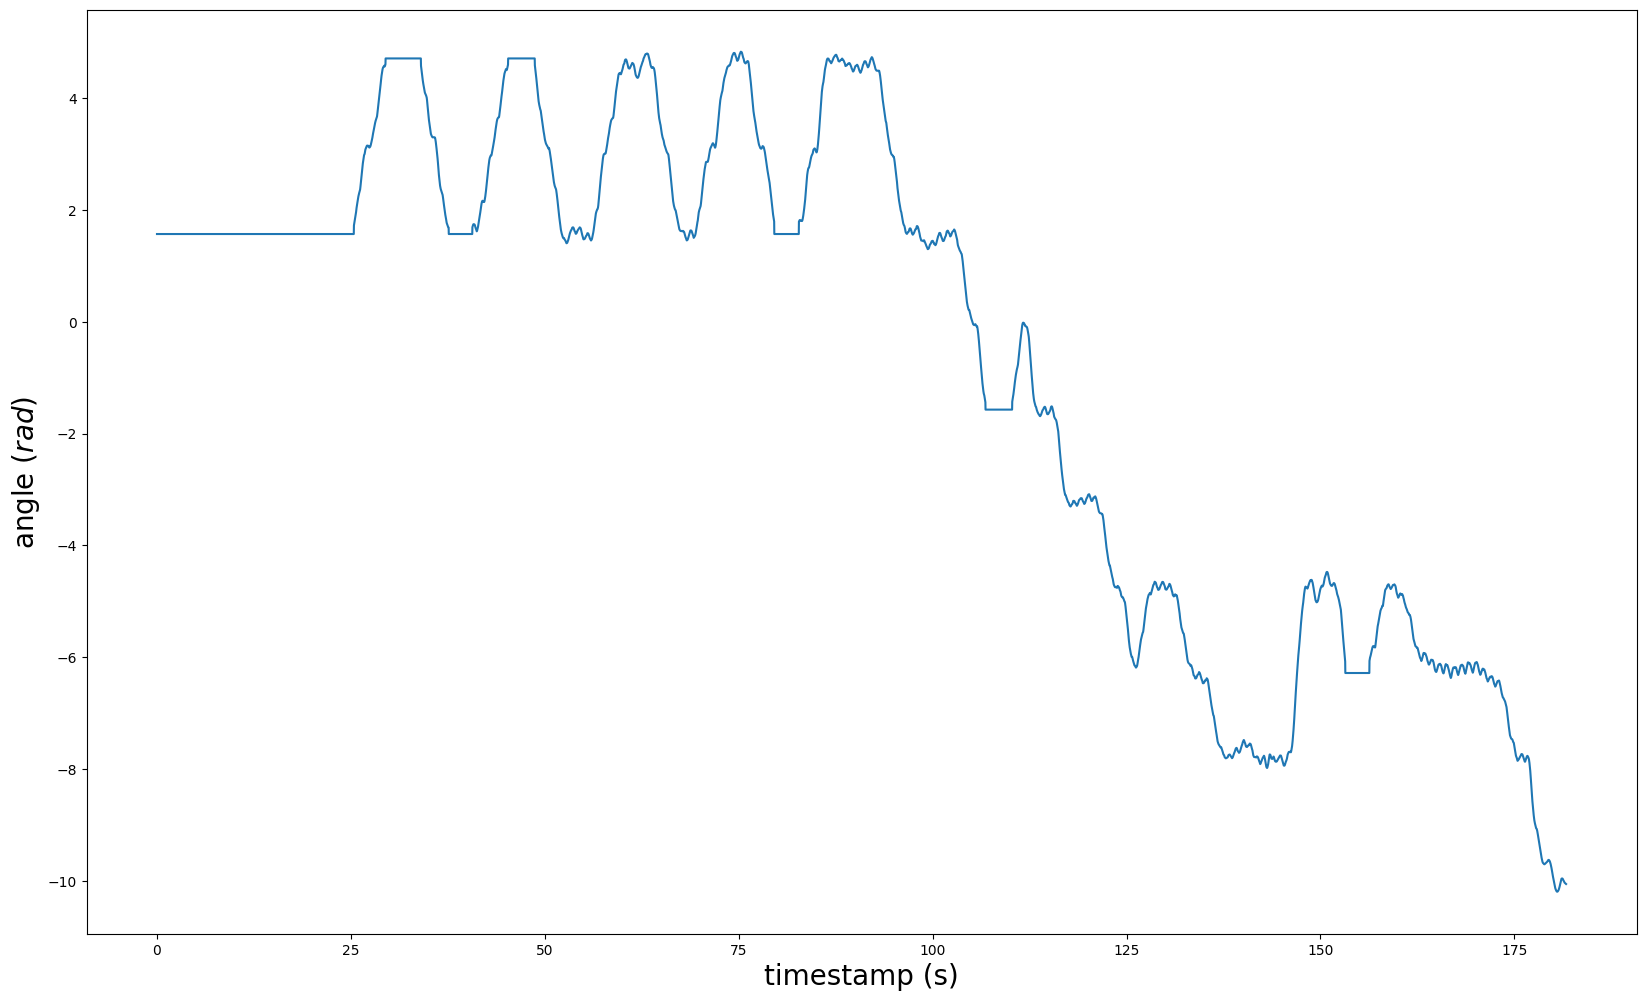

In [20]:

correct_angle_df=correct_angle(stable_angle_df,'x')

plt.plot(correct_angle_df.ts, correct_angle_df['x'])
plt.xlabel("timestamp (s)",fontsize=20)
plt.ylabel("angle ($rad$)",fontsize=20)
plt.show()

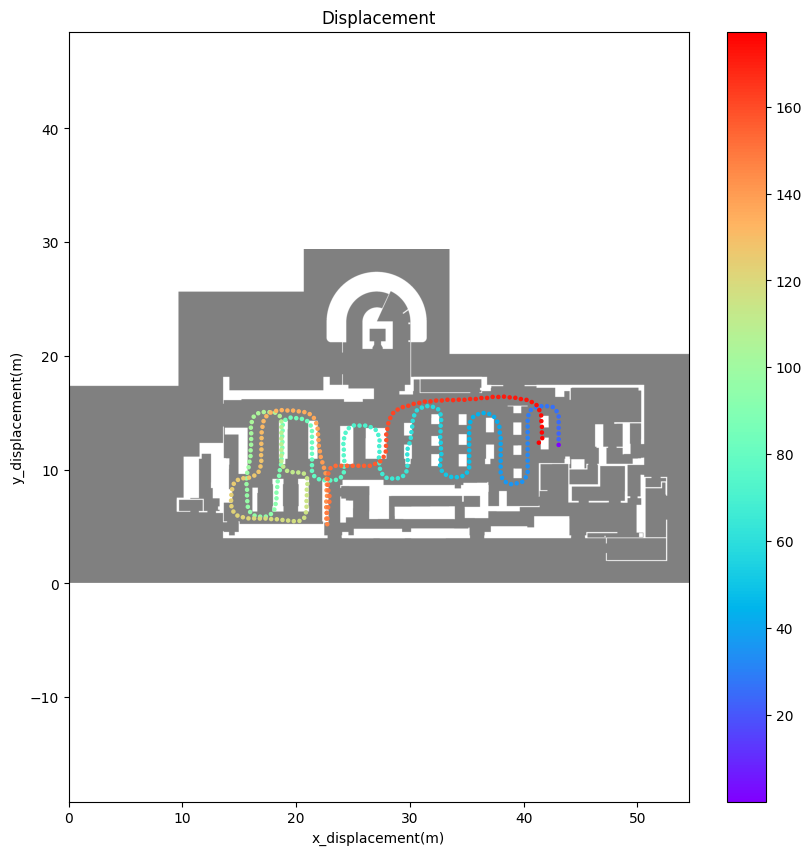

In [21]:

correct_angle_df_displacement = estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
    correct_angle_df, acc, peaks, 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]}, gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(correct_angle_df_displacement.x_displacement, correct_angle_df_displacement.y_displacement,
                c=correct_angle_df_displacement.ts, cmap="rainbow",s=5))

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()






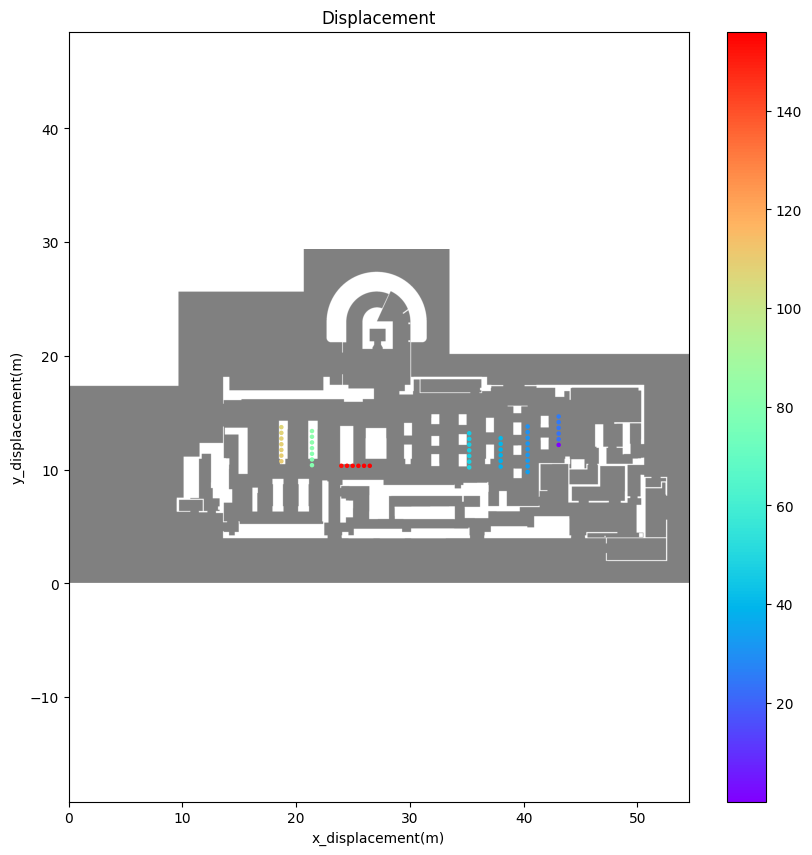

               ts  x_displacement  y_displacement is_vertical_or_horizontal  \
0        0.004059       43.079905       12.163538                       NaN   
2300    22.887179       43.088153       12.663470                      True   
2363    23.518216       43.041284       13.161269                      True   
2419    24.075389       43.061444       13.660862                      True   
2472    24.600236       43.029844       14.159863                      True   
2520    25.076593       43.007469       14.659362                      True   
2578    25.653061       42.826994       15.125655                     False   
2625    26.120688       42.485945       15.491285                     False   
2689    26.761847       41.991038       15.562464                     False   
2741    27.276752       41.491045       15.559657                      True   
2796    27.823976       40.999993       15.465490                     False   
2843    28.290371       40.559536       15.228851   

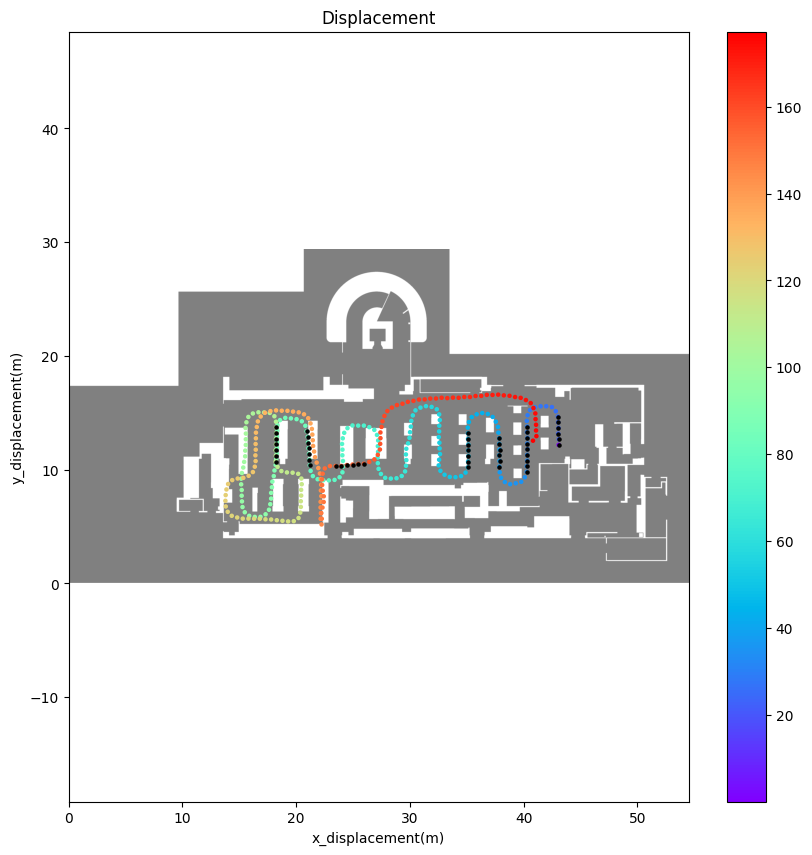

In [22]:

def match_data(angle_df: pd.DataFrame, peek_t: pd.Series):
    matched_df = pd.DataFrame()
    for t in peek_t:
        matched_row = angle_df[np.isclose(
            angle_df['ts'], t, atol=0.005)]
        matched_df = pd.concat([matched_df, matched_row])
    return matched_df

def calculate_cumulative_displacement(ts: pd.Series, angle_data: pd.Series, step_length: float, initial_point: dict[str, float], initial_timestamp: float = 0.0):
    x_displacement = step_length * np.cos(angle_data['x'])
    y_displacement = step_length * np.sin(angle_data['x'])

    init_data_frame = pd.DataFrame(
        {
            "ts": [initial_timestamp],
            "x_displacement": initial_point["x"],
            "y_displacement": initial_point["y"],
            "stable_flag":angle_data['stable_flag'].values[0]
        }
    )

    return pd.concat([init_data_frame, pd.DataFrame(
        {
            "ts": ts,
            "x_displacement": x_displacement.cumsum()+initial_point["x"],
            "y_displacement": y_displacement.cumsum()+initial_point["y"],
            "stable_flag":angle_data['stable_flag']
        }
    )])
def convert_to_peek_angle_and_compute_displacement_by_angle(
    angle: pd.DataFrame, acc: pd.DataFrame, peaks: np.ndarray, step_length: float, initial_point: dict[str, float], initial_timestamp: float = 0.0
):

    # 歩行タイミング時の角度をmatch_data関数を用いて取得
    angle_in_step_timing = match_data(angle, acc.ts[peaks])


    # 累積変位を計算
    cumulative_displacement_df = calculate_cumulative_displacement(
        angle_in_step_timing.ts, angle_in_step_timing, step_length, initial_point, initial_timestamp)

    return cumulative_displacement_df

correct_angle_df_displacement=convert_to_peek_angle_and_compute_displacement_by_angle(
    correct_angle_df, acc, peaks, 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]}, gt_ref['%time'][0])

# print(correct_angle_df_displacement)

# stable_flagがtrueのもののみを描く
estimate.plot_map(map_dict,floor_name, dx, dy)

plt.colorbar(
    plt.scatter(correct_angle_df_displacement.x_displacement[correct_angle_df_displacement['stable_flag']], correct_angle_df_displacement.y_displacement[correct_angle_df_displacement['stable_flag']],
                c=correct_angle_df_displacement.ts[correct_angle_df_displacement['stable_flag']], cmap="rainbow",s=5))

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



# straight_angle_displacementにcorrect_angle_df_displacementのstable_flagを追加

straight_angle_displacement['stable_flag']=correct_angle_df_displacement['stable_flag']
print(straight_angle_displacement)


estimate.plot_map(map_dict,floor_name, dx, dy)

# 普通に表示
plt.colorbar(
    plt.scatter(straight_angle_displacement.x_displacement, straight_angle_displacement.y_displacement,
                c=straight_angle_displacement.ts, cmap="rainbow",s=5))

# stable_flagがtrueのものは黒色で表示
plt.scatter(straight_angle_displacement.x_displacement[straight_angle_displacement['stable_flag']], straight_angle_displacement.y_displacement[straight_angle_displacement['stable_flag']],
                c='k',s=5)




plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()







               ts         x
1        0.013075 -0.155021
2        0.023024 -0.155632
3        0.032974 -0.155632
4        0.042923 -0.154410
5        0.052873 -0.155632
6        0.062822 -0.158686
7        0.072772 -0.166627
8        0.082721 -0.169071
9        0.092671 -0.169071
10       0.102620 -0.164795
11       0.112570 -0.155021
12       0.122519 -0.141582
13       0.132469 -0.125088
14       0.142418 -0.106152
15       0.152368 -0.085382
16       0.162317 -0.065834
17       0.172267 -0.043233
18       0.182216 -0.010857
19       0.192166  0.008691
20       0.202115  0.030071
21       0.212065  0.045954
22       0.222014  0.053895
23       0.231964  0.056949
24       0.241914  0.054506
25       0.251863  0.045954
26       0.261812  0.039845
27       0.271762  0.031904
28       0.281712  0.026406
29       0.291661  0.025795
30       0.301611  0.023352
31       0.311560  0.025795
32       0.321510  0.033737
33       0.331459  0.041678
34       0.341409  0.053895
35       0.351358  0

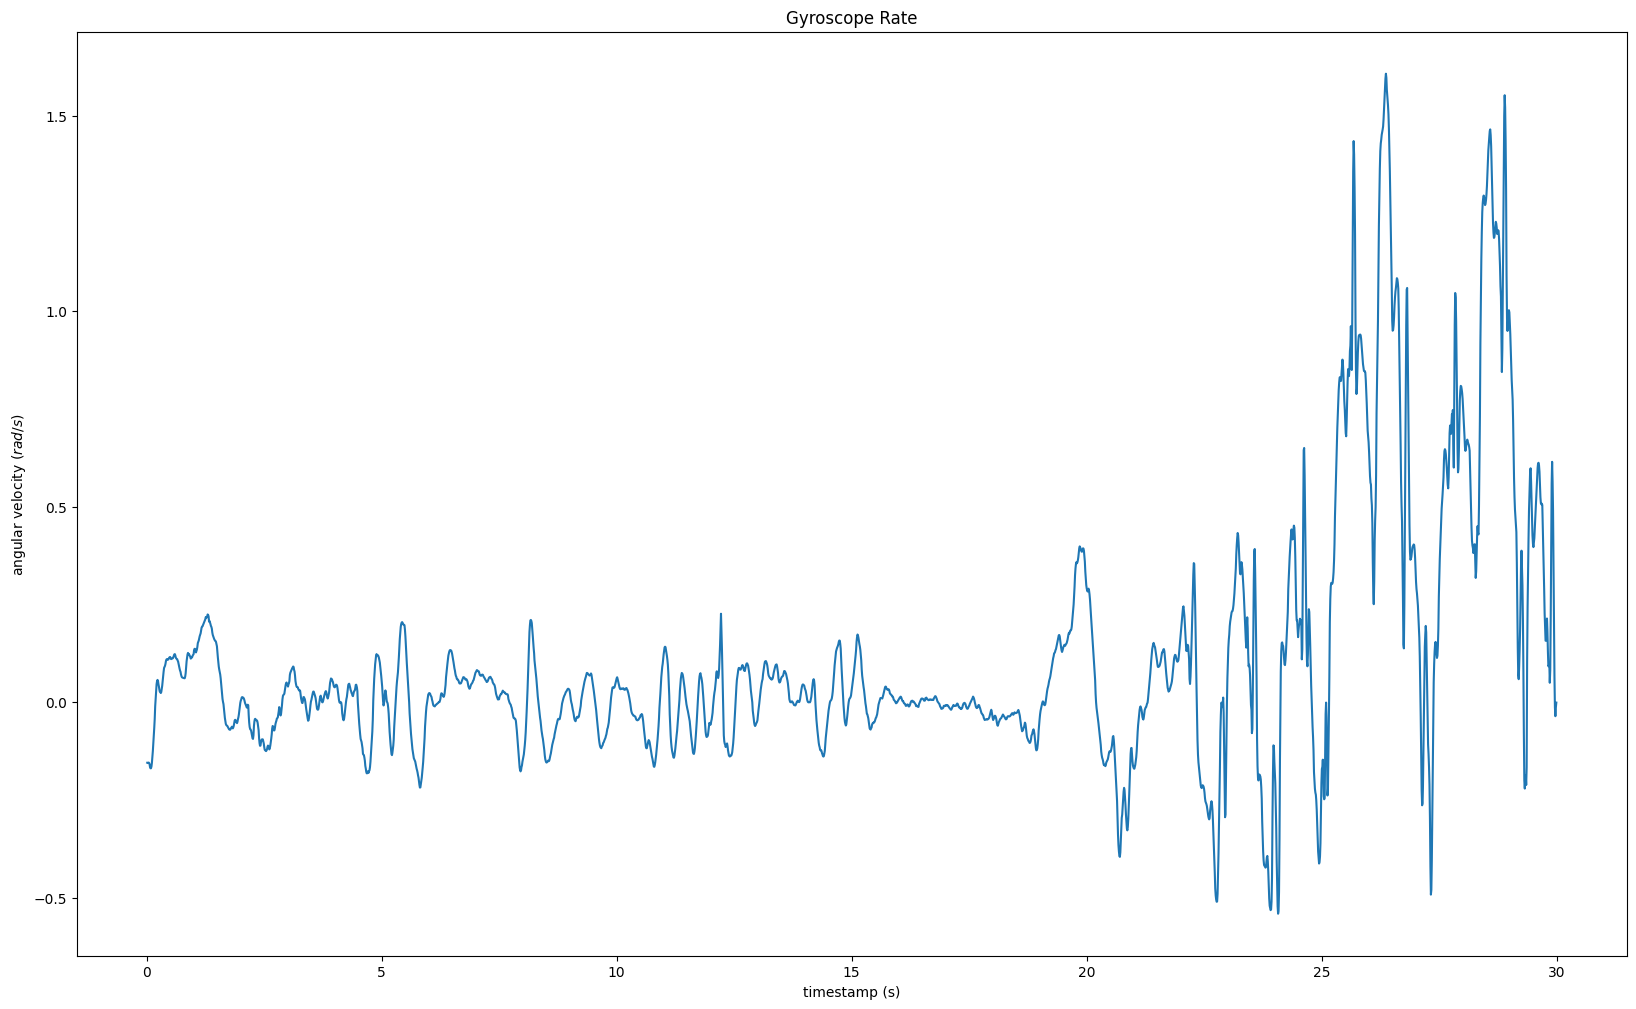

In [23]:

straight_gyro = convert_to_gyro_rate(straight_angle)

straight_gyro_normalized = straight_gyro.copy()

print(straight_gyro_normalized)

# 時間を50秒までに絞る
straight_gyro_normalized = straight_gyro_normalized[straight_gyro_normalized.ts < 30]



plt.plot(straight_gyro_normalized.ts, straight_gyro_normalized['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angular velocity ($rad/s$)")
plt.title("Gyroscope Rate")
plt.show()

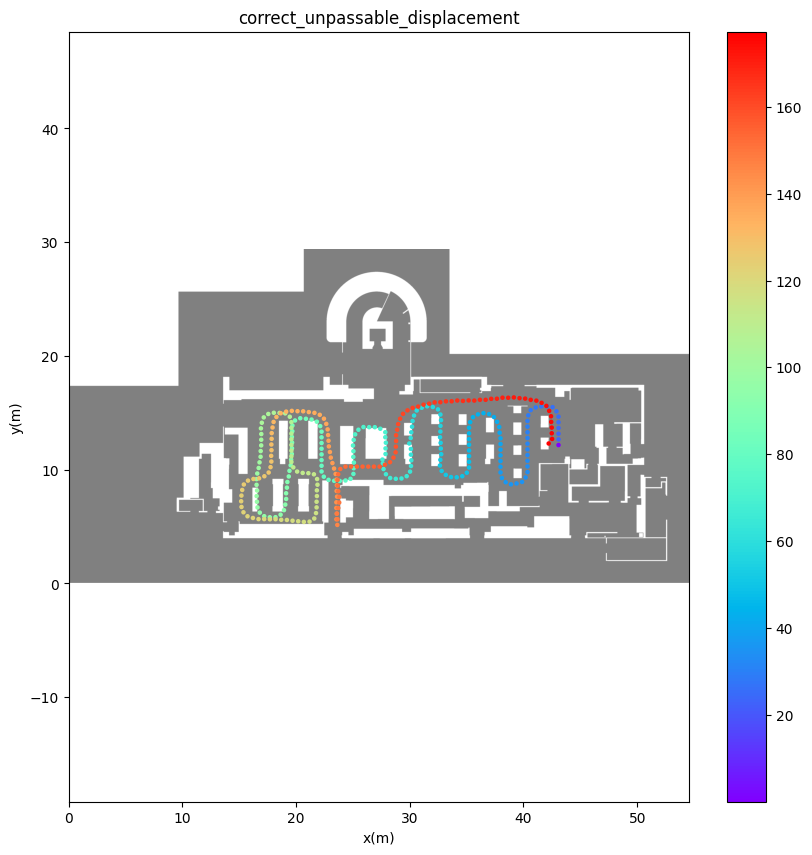

In [24]:
correct_unpassable_displacement = estimate.correct_unpassable_points(correct_angle_df_displacement[straight_angle_displacement['ts']<180], map_dict, floor_name, dx, dy)


# correct_unpassable_displacement = estimate.correct_unpassable_points(straight_angle_displacement[straight_angle_displacement['ts']<180], map_dict, floor_name, dx, dy)


estimate.plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement['x_displacement'],
        correct_unpassable_displacement['y_displacement'],
        c=correct_unpassable_displacement['ts'],
        cmap='rainbow',
        s=5
    )
)

plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.title('correct_unpassable_displacement')
plt.show()
